In [1]:
!pip install category_encoders

     |████████████████████████████████| 86 kB 3.7 MB/s 


In [2]:
!pip install yellowbrick

In [3]:
!pip install category_encoders

In [4]:
!pip install seaborn

In [5]:
!pip install squarify

In [6]:
!pip install sklearn

In [7]:
# Import Libraries
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import squarify
import os

# Collections
from collections import Counter
from operator import attrgetter
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from functools import reduce
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Imputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer
from PIL import Image

# Transformer/Encoder
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce 

# Scaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, MinMaxScaler

# Power Transformer
from sklearn.preprocessing import PowerTransformer
from scipy.spatial.distance import cdist,pdist
from sklearn.metrics import silhouette_score

# Clustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward, average, complete
import scipy.cluster.hierarchy as shc

# Metric Evaluation
import warnings
warnings.filterwarnings('ignore')

# GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


# __``Introduction``__

<hr>

**Proyek ini mencakup Segmentasi Seller Menggunakan Domain Knowledge, KMeans, Agglomerative (Ward, Average, dan Complete), dan Clustering DBScan berdasarkan RFM (Recency, Frequency, Monetary) dari Customer Analytics**

# __``Background``__

<hr>

Dataset yang digunakan dalam project ini adalah dataset yang disediakan oleh Olist, yakni E-commerce terbesar yang berada di Brazil. Sebagai E-commerce, Olist dapat menghubungkan pelaku-pelaku bisnis dan customer dalam website-nya. Fokus utama dalam bisnis sejenis ini adalah untuk memberikan pelayanan terbaik kepada customer melalui pelayanan yang diberikan oleh para seller (pelaku bisnis). Seller dalam e-commerce ini dapat terdiri dari banyak kategori (bisnis besar, menengah, maupun kecil). Keberagaman segment dan karakteristik tiap pelaku bisnis atau seller maupun customer dapat sangat beragam dan akan sangat sulit jika Olist belum mengetahui perbedaan karakteristik yang ada tersebut. 

Kita dapat memanfaatkan perbedaan dan persamaan karakteristik ini untuk memisahkan customer menjadi beberapa kelompok, dan kemudian menggunakan karakteristik kelompok tersebut untuk lebih memahami customer. Dengan menggunakan pengetahuan ini, Olist dapat belajar tentang perilaku belanja berbagai jenis customer.

Kemudian dengan memanfaaatkan segmentasi seller, Olist dapat belajar tentang karakteristik seller mengembangkan produk penawaran yang berbeda untuk setiap kelompok seller tersebut.

Ketika kita memahami karakteristik customer dan segmentasi seller, kita dapat menganalisis hubungan antara seller dan customer dalam e-commerce Olist itu sendiri, dan dapat memberikan informasi kepada perusahaan tentang apa yang diharapkan customer dan kualitas pelayanan apa yang perlu ditingkatkan seller. Dengan bertindak berdasarkan hasil analisis ini, perusahaan dapat meningkatkan keterlibatan customer dengan meningkatkan kepuasannya dalam berbelanja di Olist.

# __``Problem Statement``__

<hr>

Berdasarkan latar belakang tersebut, maka rumusan masalah dalam proyek kami yaitu sebagai berikut:

- Mengelompokkan pelanggan berdasarkan perilakunya sehingga dibagi menjadi beberapa segmen berdasarkan RFM Analytics.

- Menemukan karakteristik seller yang dari tiap seller dengan menggunakan metode Clustering



# __``Data Understanding``__

<hr>

Olist adalah e-commerce terbesar yang didirikan pada Februari 2015 oleh Tiago Dalvi. Dataset yang kami gunakan merupakan kumpulan data yang terjadi dari 2016-2018. Data ini adalah data komersial real, telah dianonimkan. Dataset ini disediakan dengan oleh Olist dan dapat diakses melalui https://www.kaggle.com/olistbr/brazilian-ecommerce. Adapun skema transaksi yang terjadi dalam Olist yaitu sebagai berikut: Pertaman, setelah customer membeli produk dari Olist, seller akan diberitahu untuk memenuhi pesanan tersebut. Setelah customer menerima produk, atau perkiraan tanggal pengiriman jatuh tempo, customer akan mendapatkan survei kepuasan melalui email dimana ia dapat memberikan catatan untuk pengalaman pembelian dan beberapa komentar.

## Attribute Information:
| Attribute   | Data Type    | Description |
| ----------- | -----------  | ----------- |
| order_id    | object        | Unique ID generated on every transaction |
| order_purchase_stamp  | datetime64[s] | Timestamp generated on every purchase |
| product_id  | object  | Unique ID to identify different product |
| price | float64 | Price of product |
| payment_type | object | Payment method used by customer during transaction
| review_score | float64 | Customer satisfaction scale, ranging from 1-5
| customer_unique_id | object | Unique ID representing each customer making a transaction |
| product_category_name_english | object | Translation of product category name in English |
| delivery_delay | float64 | Difference in days from estimated delivery and delivered date |
| month_purchase | int64 | To identify which month |
| year_purchase | int64 | To identify which year |
| payment_value | float64 | A total of amount money customer need to pay to successful transaction |
| shipping_limit_date | object | The estimated delivery date is when a customer can reasonably expect the order to arrive. |
| customer_id | object | Unique customer id to merge with orders dataset |
| customer_zip_code_prefix | int64 | represent first five zip code of geolocation customer |
| customer_city	| object |a customer city name in Brazil |
| customer_state | object | represent 2 letters of name customer sate |
| geolocation_zip_code_prefix | int64 | represent first five zip code of geolocation city and state |
| geolocation_lat | float64 | Geolocation latitude	 |
| geolocation_lng | float64 | Geolocation longitude	 |
| geolocation_city | object | City name |
| geolocation_state | object | represent 2 letter of state where the geolocation is |
| freight_value | float64 | a price at which a certain cargo is delivered from one point to another |



# __``RFM Customer Analysis``__

<hr>

## **Load Dataset**

In [8]:
# Load Dataset
customers_dataset = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_customers_dataset.csv")
order_items_dataset = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_order_items_dataset.csv")
order_payments_dataset = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_order_payments_dataset.csv")
order_reviews_dataset = pd.read_csv('/content/drive/MyDrive/Alpha Engineering/olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_orders_dataset.csv")
products_dataset  = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_products_dataset.csv")
sellers_dataset = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_sellers_dataset.csv")
product_category_name_translation = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/product_category_name_translation.csv")

## **Data Preprocessing**

In [9]:
pd.set_option('display.max_columns', 500)

In [10]:
order_items_dataset.drop(['shipping_limit_date'],axis=1,inplace=True)
customers_dataset.drop(['customer_zip_code_prefix'],axis=1,inplace=True)

# Kita hanya akan menggunakan dataset dengan status order delivered
orders_dataset=orders_dataset.loc[orders_dataset['order_status']=='delivered']
orders_dataset['order_purchase_timestamp'] = pd.to_datetime(orders_dataset['order_purchase_timestamp'])
order_reviews_dataset['review_creation_date'] = pd.to_datetime(order_reviews_dataset['review_creation_date'])
order_reviews_dataset['review_answer_timestamp'] = pd.to_datetime(order_reviews_dataset['review_answer_timestamp'])
orders_dataset['order_estimated_delivery_date'] = pd.to_datetime(orders_dataset['order_estimated_delivery_date'])
orders_dataset['order_delivered_customer_date'] = pd.to_datetime(orders_dataset['order_delivered_customer_date'])
orders_dataset['diff_forecast_delivery']=((orders_dataset['order_estimated_delivery_date'])-(orders_dataset['order_delivered_customer_date'])).dt.days
orders_dataset['diff_forecast_delivery'].fillna(0,inplace=True)
products_dataset['product_category_name'].fillna('Uninformed',inplace =True)
orders_dataset.dropna(inplace=True)
orders_dataset['diff_forecast_delivery']=orders_dataset['diff_forecast_delivery'].astype('int64')

In [11]:
orders_dataset['year_purchase'] = orders_dataset['order_purchase_timestamp'].dt.year
orders_dataset['month_purchase'] = orders_dataset['order_purchase_timestamp'].dt.month
orders_dataset['day_purchase'] = orders_dataset['order_purchase_timestamp'].dt.day
orders_dataset['day_week_purchase'] = orders_dataset['order_purchase_timestamp'].dt.weekday

# Drop dataset yang tidak diperlukan
orders_dataset.drop(['order_approved_at'],axis=1,inplace=True)
products_dataset.drop(['product_name_lenght'],axis=1,inplace=True)
products_dataset.drop(['product_photos_qty'],axis=1,inplace=True)
products_dataset.drop(['product_description_lenght'],axis=1,inplace=True)
products_dataset.drop(['product_weight_g'],axis=1,inplace=True)
products_dataset.drop(['product_length_cm'],axis=1,inplace=True)
products_dataset.drop(['product_height_cm'],axis=1,inplace=True)
products_dataset.drop(['product_width_cm'],axis=1,inplace=True)

In [12]:
day_name = []
for d in orders_dataset.day_week_purchase:
  if d == 6:
    d = 'Sunday'
  elif d == 0:
    d = 'Monday'
  elif d == 1:
    d = 'Tuesday'
  elif d == 2:
    d = 'Wednesday'
  elif d == 3:
    d = 'Thursday'
  elif d == 4:
    d = 'Friday'
  else:
    d = 'Saturday'
  day_name.append(d)
orders_dataset['day_week_purchase'] = day_name

In [13]:
order_reviews_dataset['review_comment_title'].fillna('Untitled',inplace =True)
order_reviews_dataset['review_comment_message'].fillna('No Message',inplace =True)
order_reviews_dataset.drop(['review_id'],axis=1,inplace=True)
order_reviews_dataset.drop(['review_comment_title'],axis=1,inplace=True)
order_reviews_dataset.drop(['review_comment_message'],axis=1,inplace=True)
order_reviews_dataset=order_reviews_dataset.drop_duplicates(subset='order_id', keep='last')

order_reviews_dataset['year_review_creation'] = order_reviews_dataset['review_creation_date'].dt.year
order_reviews_dataset['month_review_creation'] = order_reviews_dataset['review_creation_date'].dt.month
order_reviews_dataset['day_review_creation'] = order_reviews_dataset['review_creation_date'].dt.day
order_reviews_dataset['day_week_review_creation'] = order_reviews_dataset['review_creation_date'].dt.weekday

order_reviews_dataset['year_review_answer'] = order_reviews_dataset['review_answer_timestamp'].dt.year
order_reviews_dataset['month_review_answer'] = order_reviews_dataset['review_answer_timestamp'].dt.month
order_reviews_dataset['day_review_answer'] = order_reviews_dataset['review_answer_timestamp'].dt.day
order_reviews_dataset['day_week_review_answer'] = order_reviews_dataset['review_answer_timestamp'].dt.weekday

In [14]:
day_name2 = []
for e in order_reviews_dataset.day_week_review_creation:
  if e == 6:
    e = 'Sunday'
  elif e == 0:
    e = 'Monday'
  elif e == 1:
    e = 'Tuesday'
  elif e == 2:
    e = 'Wednesday'
  elif e == 3:
    e = 'Thursday'
  elif e == 4:
    e = 'Friday'
  else:
    e = 'Saturday'
  day_name2.append(e)
order_reviews_dataset['day_week_review_creation'] = day_name2

In [15]:
day_name3 = []
for f in order_reviews_dataset.day_week_review_answer:
  if f == 6:
    f = 'Sunday'
  elif f == 0:
    f = 'Monday'
  elif f == 1:
    f = 'Tuesday'
  elif f == 2:
    f = 'Wednesday'
  elif f == 3:
    f = 'Thursday'
  elif f == 4:
    f = 'Friday'
  else:
    f = 'Saturday'
  day_name3.append(f)
order_reviews_dataset['day_week_review_answer'] = day_name3

In [16]:
data = pd.merge(orders_dataset,order_items_dataset, on='order_id',how='left')
data = pd.merge(data, sellers_dataset, on='seller_id', how='left')
data = pd.merge(data, products_dataset, on='product_id', how='left')
data = pd.merge(data, customers_dataset, on='customer_id', how='left')
data = pd.merge(data,order_reviews_dataset, on='order_id', how='left')
data = pd.merge(data,order_payments_dataset, on='order_id', how='left')

In [17]:
southeast = ['SP', 'RJ', 'ES','MG']
northeast= ['MA', 'PI', 'CE', 'RN', 'PE', 'PB', 'SE', 'AL', 'BA']
north =  ['AM', 'RR', 'AP', 'PA', 'TO', 'RO', 'AC']
midwest = ['MT', 'GO', 'MS' ,'DF' ]
south = ['SC', 'RS', 'PR']

data.loc[data['customer_state'].isin(southeast), 'customer_region'] = 'South East'
data.loc[data['customer_state'].isin(northeast), 'customer_region'] = 'North East'
data.loc[data['customer_state'].isin(north), 'customer_region'] = 'North'
data.loc[data['customer_state'].isin(midwest), 'customer_region'] = 'Midwest'
data.loc[data['customer_state'].isin(south), 'customer_region'] = 'South'

data.loc[data['seller_state'].isin(southeast), 'seller_region'] = 'South East'
data.loc[data['seller_state'].isin(northeast), 'seller_region'] = 'North East'
data.loc[data['seller_state'].isin(north), 'seller_region'] = 'North'
data.loc[data['seller_state'].isin(midwest), 'seller_region'] = 'Midwest'
data.loc[data['seller_state'].isin(south), 'seller_region'] = 'South'

In [18]:
data['product_category_name'].unique()

array(['utilidades_domesticas', 'perfumaria', 'automotivo', 'pet_shop',
       'papelaria', 'moveis_decoracao', 'moveis_escritorio',
       'ferramentas_jardim', 'informatica_acessorios', 'cama_mesa_banho',
       'brinquedos', 'construcao_ferramentas_construcao', 'telefonia',
       'beleza_saude', 'eletronicos', 'bebes', 'cool_stuff',
       'relogios_presentes', 'climatizacao', 'esporte_lazer',
       'livros_interesse_geral', 'eletroportateis', 'alimentos',
       'malas_acessorios', 'fashion_underwear_e_moda_praia', 'Uninformed',
       'fashion_bolsas_e_acessorios', 'instrumentos_musicais',
       'construcao_ferramentas_iluminacao', 'livros_tecnicos',
       'construcao_ferramentas_jardim', 'eletrodomesticos',
       'market_place', 'agro_industria_e_comercio', 'artigos_de_festas',
       'casa_conforto', 'cds_dvds_musicais',
       'industria_comercio_e_negocios', 'consoles_games', 'moveis_quarto',
       'construcao_ferramentas_seguranca', 'telefonia_fixa', 'bebidas',
       '

In [19]:
# Translate product_category_name
data['product_category_name'].replace('utilidades_domesticas', 'housewares',inplace = True)
data['product_category_name'].replace('perfumaria', 'perfumery',inplace = True)
data['product_category_name'].replace('automotivo', 'automotive',inplace = True)
data['product_category_name'].replace('papelaria', 'stationary store',inplace = True)
data['product_category_name'].replace('moveis_decoracao', 'furniture_decoration',inplace = True)
data['product_category_name'].replace('moveis_escritorio', 'office furniture',inplace = True)
data['product_category_name'].replace('ferramentas_jardim', 'garden tools',inplace = True)
data['product_category_name'].replace('informatica_acessorios', 'computer accessories',inplace = True)
data['product_category_name'].replace('cama_mesa_banho', 'bed table bath',inplace = True)
data['product_category_name'].replace('brinquedos', 'toys',inplace = True)
data['product_category_name'].replace('construcao_ferramentas_construcao', 'construction_tools_construction',inplace = True)
data['product_category_name'].replace('telefonia', 'wireless',inplace = True)
data['product_category_name'].replace('beleza_saude', 'beauty_health',inplace = True)
data['product_category_name'].replace('eletronicos', 'electronic',inplace = True)
data['product_category_name'].replace('bebes', 'babies',inplace = True)
data['product_category_name'].replace('relogios_presentes', 'gifts watches',inplace = True)
data['product_category_name'].replace('climatizacao', 'air conditioning',inplace = True)
data['product_category_name'].replace('esporte_lazer', 'sport leisure',inplace = True)
data['product_category_name'].replace('eletroportateis', 'small appliances',inplace = True)
data['product_category_name'].replace('alimentos', 'foods',inplace = True)
data['product_category_name'].replace('malas_acessorios', 'bags_accessories',inplace = True)
data['product_category_name'].replace('fashion_underwear_e_moda_praia', 'fashion underwear beachwear',inplace = True)
data['product_category_name'].replace('fashion_bolsas_e_acessorios', 'fashion bags and accessories',inplace = True)
data['product_category_name'].replace('instrumentos_musicais', 'musical instruments',inplace = True)
data['product_category_name'].replace('construcao_ferramentas_iluminacao', 'construction tools lighting',inplace = True)
data['product_category_name'].replace('livros_tecnicos', 'technical books',inplace = True)
data['product_category_name'].replace('construcao_ferramentas_jardim', 'construction garden tools',inplace = True)
data['product_category_name'].replace('eletrodomesticos', 'home appliances',inplace = True)
data['product_category_name'].replace('agro_industria_e_comercio', 'agro industry and commerce',inplace = True)
data['product_category_name'].replace('artigos_de_festas', 'party supplies',inplace = True)
data['product_category_name'].replace('casa_conforto', 'home_comfort',inplace = True)
data['product_category_name'].replace('cds_dvds_musicais', 'music cds dvds',inplace = True)
data['product_category_name'].replace('industria_comercio_e_negocios', 'industry commerce and business',inplace = True)
data['product_category_name'].replace('consoles_games', 'game consoles',inplace = True)
data['product_category_name'].replace('moveis_quarto', 'bedroom furniture',inplace = True)
data['product_category_name'].replace('construcao_ferramentas_seguranca', 'construction_tools_security',inplace = True)
data['product_category_name'].replace('telefonia_fixa', 'fixed telephony',inplace = True)
data['product_category_name'].replace('bebidas', 'beverage',inplace = True)
data['product_category_name'].replace('moveis_cozinha_area_de_servico_jantar_e_jardim', 'furniture kitchen service area dinner_and_garden',inplace = True)
data['product_category_name'].replace('fashion_calcados', 'fashion_shoes',inplace = True)
data['product_category_name'].replace('casa_construcao', 'house_construction',inplace = True)
data['product_category_name'].replace('eletrodomesticos_2', 'home appliances_2',inplace = True)
data['product_category_name'].replace('cine_foto', 'cine photo',inplace = True)
data['product_category_name'].replace('moveis_sala', 'living room furniture',inplace = True)
data['product_category_name'].replace('artes', 'Arts',inplace = True)
data['product_category_name'].replace('fashion_roupa_masculina', 'fashion_clothes_men',inplace = True)
data['product_category_name'].replace('artigos_de_natal', 'Christmas articles',inplace = True)
data['product_category_name'].replace('alimentos_bebidas', 'food and beverage',inplace = True)
data['product_category_name'].replace('tablets_impressao_imagem', 'tablets_impression_image',inplace = True)
data['product_category_name'].replace('fashion_esporte', 'fashion_sport',inplace = True)
data['product_category_name'].replace('portateis_cozinha_e_preparadores_de_alimentos', 'portable kitchen food preparers',inplace = True)
data['product_category_name'].replace('la_cuisine', 'the kitchen',inplace = True)
data['product_category_name'].replace('flores', 'flowers',inplace = True)
data['product_category_name'].replace('pcs', 'PCs',inplace = True)
data['product_category_name'].replace('casa_conforto_2', 'home_comfort_2',inplace = True)
data['product_category_name'].replace('portateis_casa_forno_e_cafe', 'home_oven_and_cafe laptops',inplace = True)
data['product_category_name'].replace('construcao_ferramentas_ferramentas', 'construction_tools_tools',inplace = True)
data['product_category_name'].replace('moveis_colchao_e_estofado', 'mattress and upholstery furniture',inplace = True)
data['product_category_name'].replace('sinalizacao_e_seguranca', 'signage and security',inplace = True)
data['product_category_name'].replace('fashion_roupa_feminina', 'fashion_women_clothes',inplace = True)
data['product_category_name'].replace('fraldas_higiene', 'hygiene diapers',inplace = True)
data['product_category_name'].replace('livros_importados', 'imported_books',inplace = True)
data['product_category_name'].replace('musica', 'music',inplace = True)
data['product_category_name'].replace('artes_e_artesanato', 'arts_and_crafts',inplace = True)
data['product_category_name'].replace('fashion_roupa_infanto_juvenil', 'fashion_clothes_children_youth',inplace = True)
data['product_category_name'].replace('seguros_e_servicos', 'insurance_and_services',inplace = True)

In [20]:
data['payment_type'].unique()

array(['credit_card', 'voucher', 'boleto', 'debit_card', nan],
      dtype=object)

In [21]:
# Translate payment_type
data['payment_type'].replace('boleto', 'ticket',inplace = True)

In [22]:
# Pisahkan coloumn order_purchase_time berdasarkan tanggal dan waktu
data['purchase_date']=data['order_purchase_timestamp'].dt.date

# Pembulatan waktu per 360 menit atau setiap 6 jam
data['time_purchase']=data['order_purchase_timestamp'].dt.round('360min')
data['time_purchase']=data['time_purchase'].dt.time

data['time_review_answer']=data['review_answer_timestamp'].dt.round('360min')
data['time_review_answer']=data['time_review_answer'].dt.time

# Buat kolom baru yang berisikan bulan dan tahun
data['month_and_year_purchase']=data['order_purchase_timestamp'].dt.strftime('%m-%Y')

In [23]:
data = data[['order_id','order_status','order_purchase_timestamp','day_purchase',
             'month_purchase','year_purchase','day_week_purchase','month_and_year_purchase',
             'purchase_date','time_purchase','payment_type','payment_sequential',
             'payment_installments','payment_value','diff_forecast_delivery',
             'product_id','product_category_name','order_item_id','price',
             'order_delivered_customer_date','order_estimated_delivery_date',
             'freight_value','review_score','customer_id','seller_id',
             'review_creation_date','year_review_creation','month_review_creation',
             'day_review_creation','day_week_review_creation', 
             'review_answer_timestamp','year_review_answer','month_review_answer',
             'day_review_answer','day_week_review_answer','time_review_answer',
             'customer_unique_id','customer_city', 'seller_city',
             'customer_state','seller_state','customer_region','seller_region']]

In [24]:
data.rename(columns={'product_category_name': 'category'}, inplace = True)
data.rename(columns={'payment_sequential': 'payment_order'}, inplace = True)
data.rename(columns={'payment_value': 'total_paid'}, inplace = True)

In [25]:
data.head()

,order_id,order_status,order_purchase_timestamp,day_purchase,month_purchase,year_purchase,day_week_purchase,month_and_year_purchase,purchase_date,time_purchase,payment_type,payment_order,payment_installments,total_paid,diff_forecast_delivery,product_id,category,order_item_id,price,order_delivered_customer_date,order_estimated_delivery_date,freight_value,review_score,customer_id,seller_id,review_creation_date,year_review_creation,month_review_creation,day_review_creation,day_week_review_creation,review_answer_timestamp,year_review_answer,month_review_answer,day_review_answer,day_week_review_answer,time_review_answer,customer_unique_id,customer_city,seller_city,customer_state,seller_state,customer_region,seller_region
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2,10,2017,Monday,10-2017,2017-10-02,12:00:00,credit_card,1.0,1.0,18.12,7,87285b34884572647811a353c7ac498a,housewares,1,29.99,2017-10-10 21:25:13,2017-10-18,8.72,4.0,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-11,2017.0,10.0,11.0,Wednesday,2017-10-12 03:43:48,2017.0,10.0,12.0,Thursday,06:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,maua,SP,SP,South East,South East
1,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2,10,2017,Monday,10-2017,2017-10-02,12:00:00,voucher,3.0,1.0,2.00,7,87285b34884572647811a353c7ac498a,housewares,1,29.99,2017-10-10 21:25:13,2017-10-18,8.72,4.0,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-11,2017.0,10.0,11.0,Wednesday,2017-10-12 03:43:48,2017.0,10.0,12.0,Thursday,06:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,maua,SP,SP,South East,South East
2,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02 10:56:33,2,10,2017,Monday,10-2017,2017-10-02,12:00:00,voucher,2.0,1.0,18.59,7,87285b34884572647811a353c7ac498a,housewares,1,29.99,2017-10-10 21:25:13,2017-10-18,8.72,4.0,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-11,2017.0,10.0,11.0,Wednesday,2017-10-12 03:43:48,2017.0,10.0,12.0,Thursday,06:00:00,7c396fd4830fd04220f754e42b4e5bff,sao paulo,maua,SP,SP,South East,South East
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,24,7,2018,Tuesday,07-2018,2018-07-24,18:00:00,ticket,1.0,1.0,141.46,5,595fac2a385ac33a80bd5114aec74eb8,perfumery,1,118.70,2018-08-07 15:27:45,2018-08-13,22.76,4.0,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-08-08,2018.0,8.0,8.0,Wednesday,2018-08-08 18:37:50,2018.0,8.0,8.0,Wednesday,18:00:00,af07308b275d755c9edb36a90c618231,barreiras,belo horizonte,BA,SP,North East,South East
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,8,8,2018,Wednesday,08-2018,2018-08-08,06:00:00,credit_card,1.0,3.0,179.12,17,aa4383b373c6aca5d8797843e5594415,automotive,1,159.90,2018-08-17 18:06:29,2018-09-04,19.22,5.0,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-18,2018.0,8.0,18.0,Saturday,2018-08-22 19:07:58,2018.0,8.0,22.0,Wednesday,18:00:00,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,guariba,GO,SP,Midwest,South East


## **Exploratory Data Analysis**

**Purchase History**

In [26]:
# Pada exploratory data analysis ini kami ingin melihat perbandingan data antara 2017-2018, namun karena data 2018 hanya tersedia hingga 8 bulan,
# maka kami melakukan filtering data 2017 hingga 8 bulan saja

filter  = data['month_purchase'].isin([1,2,3,4,5,6,7,8])
                                      
data_filter= data[filter]
data_filter

,order_id,order_status,order_purchase_timestamp,day_purchase,month_purchase,year_purchase,day_week_purchase,month_and_year_purchase,purchase_date,time_purchase,payment_type,payment_order,payment_installments,total_paid,diff_forecast_delivery,product_id,category,order_item_id,price,order_delivered_customer_date,order_estimated_delivery_date,freight_value,review_score,customer_id,seller_id,review_creation_date,year_review_creation,month_review_creation,day_review_creation,day_week_review_creation,review_answer_timestamp,year_review_answer,month_review_answer,day_review_answer,day_week_review_answer,time_review_answer,customer_unique_id,customer_city,seller_city,customer_state,seller_state,customer_region,seller_region
3,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24 20:41:37,24,7,2018,Tuesday,07-2018,2018-07-24,18:00:00,ticket,1.0,1.0,141.46,5,595fac2a385ac33a80bd5114aec74eb8,perfumery,1,118.70,2018-08-07 15:27:45,2018-08-13,22.76,4.0,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-08-08,2018.0,8.0,8.0,Wednesday,2018-08-08 18:37:50,2018.0,8.0,8.0,Wednesday,18:00:00,af07308b275d755c9edb36a90c618231,barreiras,belo horizonte,BA,SP,North East,South East
4,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08 08:38:49,8,8,2018,Wednesday,08-2018,2018-08-08,06:00:00,credit_card,1.0,3.0,179.12,17,aa4383b373c6aca5d8797843e5594415,automotive,1,159.90,2018-08-17 18:06:29,2018-09-04,19.22,5.0,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-18,2018.0,8.0,18.0,Saturday,2018-08-22 19:07:58,2018.0,8.0,22.0,Wednesday,18:00:00,3a653a41f6f9fc3d2a113cf8398680e8,vianopolis,guariba,GO,SP,Midwest,South East
6,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13 21:18:39,13,2,2018,Tuesday,02-2018,2018-02-13,00:00:00,credit_card,1.0,1.0,28.62,9,65266b2da20d04dbe00c5c2d3bb7859e,stationary store,1,19.90,2018-02-16 18:17:02,2018-02-26,8.72,5.0,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-17,2018.0,2.0,17.0,Saturday,2018-02-18 13:02:51,2018.0,2.0,18.0,Sunday,12:00:00,72632f0f9dd73dfee390c9b22eb56dd6,santo andre,mogi das cruzes,SP,SP,South East,South East
7,a4591c265e18cb1dcee52889e2d8acc3,delivered,2017-07-09 21:57:05,9,7,2017,Sunday,07-2017,2017-07-09,00:00:00,credit_card,1.0,6.0,175.26,5,060cb19345d90064d1015407193c233d,automotive,1,147.90,2017-07-26 10:57:55,2017-08-01,27.36,4.0,503740e9ca751ccdda7ba28e9ab8f608,8581055ce74af1daba164fdbd55a40de,2017-07-27,2017.0,7.0,27.0,Thursday,2017-07-27 22:48:30,2017.0,7.0,27.0,Thursday,00:00:00,80bb27c7c16e8f973207a5086ab329e2,congonhinhas,guarulhos,PR,SP,South,South East
8,6514b8ad8028c9f2cc2374ded245783f,delivered,2017-05-16 13:10:30,16,5,2017,Tuesday,05-2017,2017-05-16,12:00:00,credit_card,1.0,3.0,75.16,11,4520766ec412348b8d4caa5e8a18c464,automotive,1,59.99,2017-05-26 12:55:51,2017-06-07,15.17,5.0,9bdf08b4b3b52b5526ff42d37d47f222,16090f2ca825584b5a147ab24aa30c86,2017-05-27,2017.0,5.0,27.0,Saturday,2017-05-28 02:59:57,2017.0,5.0,28.0,Sunday,00:00:00,932afa1e708222e5821dac9cd5db4cae,nilopolis,atibaia,RJ,SP,South East,South East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115009,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06 12:58:58,6,2,2018,Tuesday,02-2018,2018-02-06,12:00:00,credit_card,1.0,3.0,195.00,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,babies,1,174.90,2018-02-28 17:37:56,2018-03-02,20.10,4.0,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,2018-03-01,2018.0,3.0,1.0,Thursday,2018-03-02 17:50:01,2018.0,3.0,2.0,Friday,18:00:00,da62f9e57a76d978d02ab5362c509660,praia grande,tupa,SP,SP,South East,South East
115010,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27 14:46:43,27,8,2017,Sunday,08-2017,2017-08-27,12:00:00,credit_card,1.0,5.0,271.01,5,b80910977a37536adeddd63663f916ad,home appliances_2,1,205.99,2017-09-21 11:24:17,2017-09-27,65.02,5.0,1aa71eb042121263aafbe80c1b562c9c,d5

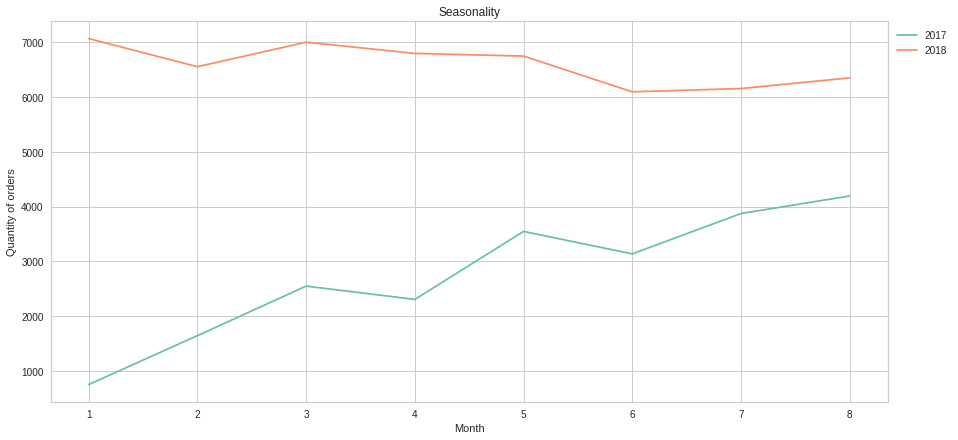

In [27]:
plt.figure(figsize=(15,7))
seasonality = data_filter.groupby(['month_purchase','year_purchase'])['order_id'].nunique().sort_values(ascending=True).reset_index()


sns.lineplot(data=seasonality, 
             x='month_purchase', 
             y='order_id', 
             hue='year_purchase', 
             legend='full',
             palette='Set2')
plt.title('Seasonality')
plt.ylabel('Quantity of orders')
plt.xlabel('Month')

# Moving the caption out of the box
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);

Puncak Purchase History terjadi pada January 2018, peningkatan ini mungkin saja terjadi karena adanya strategi marketing tertentu yang berhasil di bulan tersebut.

Sedangkan jika dilihat secara per-tahun, Quantity of Orders custemers bertambah secara signifikan dari 2017 ke 2018.

**Revenue Historic**

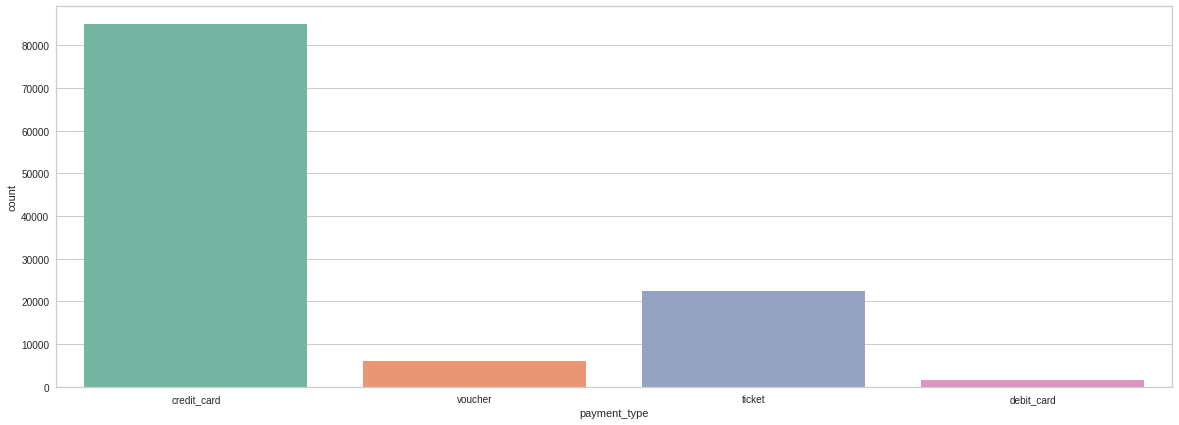

In [28]:
plt.figure(figsize=(20,7))
sns.countplot(x='payment_type', data=data, palette='Set2')

Berdasarkan hasil analisi tersebut, terlihat bahwa credit card adalah metode pembayaran yang paling sering digunakan oleh customer saat bertransaksi

(0.0, 58054.700000000004)

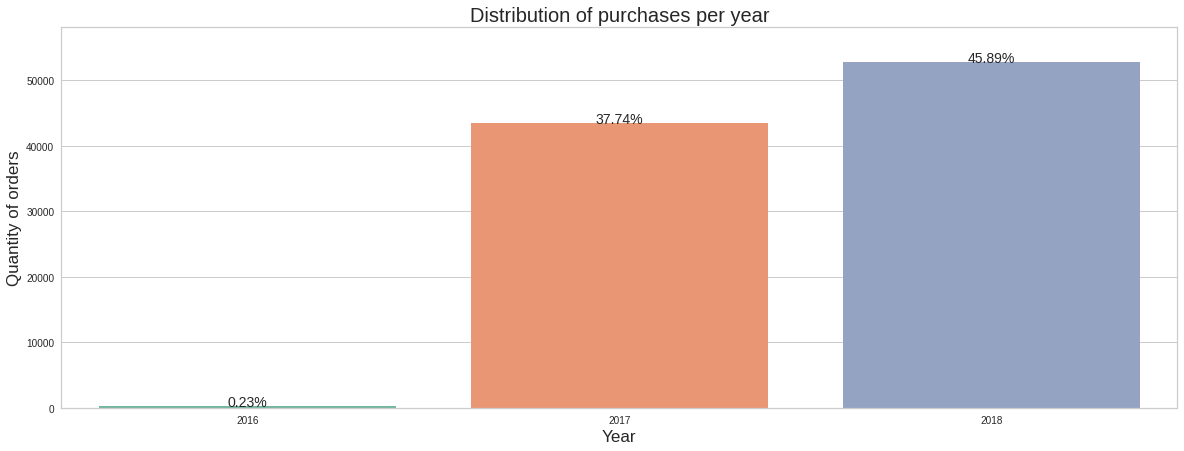

In [29]:
plt.figure(figsize=(20,7))

plt.subplot(111)
seasonality_year = data.groupby(['year_purchase'])['order_id'].nunique().sort_values(ascending=True).reset_index()
total=len(data)
g = sns.barplot(x='year_purchase', y='order_id', data=seasonality_year, palette='Set2')
g.set_title("Distribution of purchases per year", fontsize=20)
g.set_xlabel("Year", fontsize=17)
g.set_ylabel("Quantity of orders", fontsize=17)
sizes = []
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.1)

Berdasarkan analisis distribution of purchase per yaer tersebut terlihat bahwa terjadi peningkatan order yang sangat signifikan setiap tahunnya.

**Purchase Behavior**

Text(0.5, 1.0, 'Top 10 categories with the most requests')

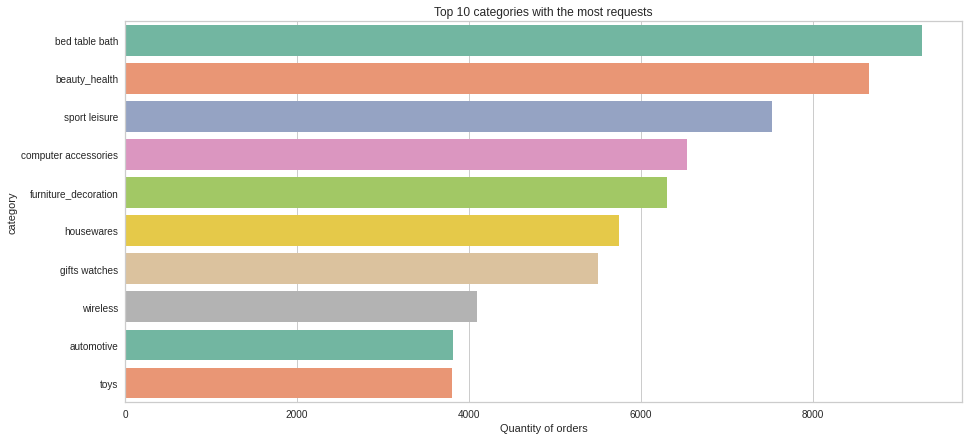

In [30]:
top_selling_products = data.groupby('category')['order_id'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(15,7))
sns.barplot(y=top_selling_products.index, x=top_selling_products, palette="Set2")
plt.xlabel('Quantity of orders')
plt.title('Top 10 categories with the most requests')

Berdasarkan grafik di atas terlihat bahwa top 10 penjualan berasal dari barang-barang yang memiliki jangka waktu pemakaian cukup lama. Hal ini mungkin saja dapat mempengaruhi churn customer.

**Distribution of orders by day of the week**

Text(0, 0.5, 'Quantity of orders')

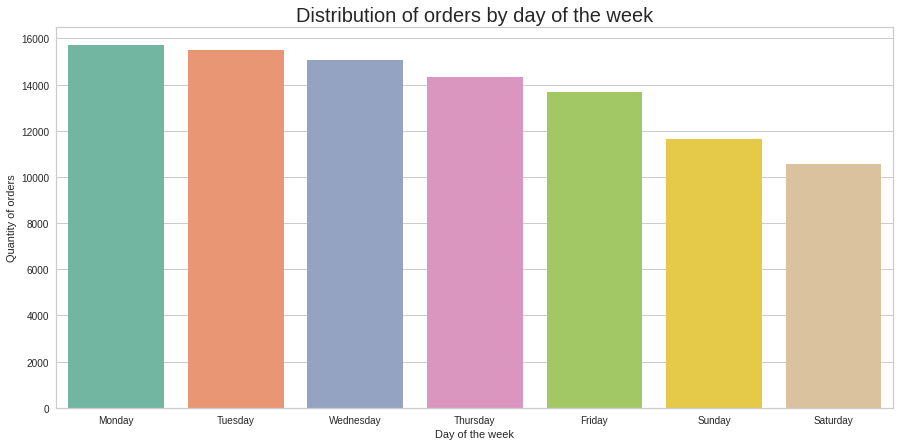

In [31]:
plt.figure(figsize=(15,7))
seasonality_week = data.groupby(['day_week_purchase'])['order_id'].nunique().sort_values(ascending=False).reset_index()
sns.barplot(x='day_week_purchase',y='order_id', data=seasonality_week, palette='Set2')
plt.title("Distribution of orders by day of the week", fontsize=20)
plt.xlabel('Day of the week')
plt.ylabel('Quantity of orders')

Berdasarkan grafik tersebut, dapat terlihat bahwa arus pembelian cenderung meningkat selama hari kerja

**Distribution of orders by time of the day**

Text(0.5, 0, 'Quantity of orders')

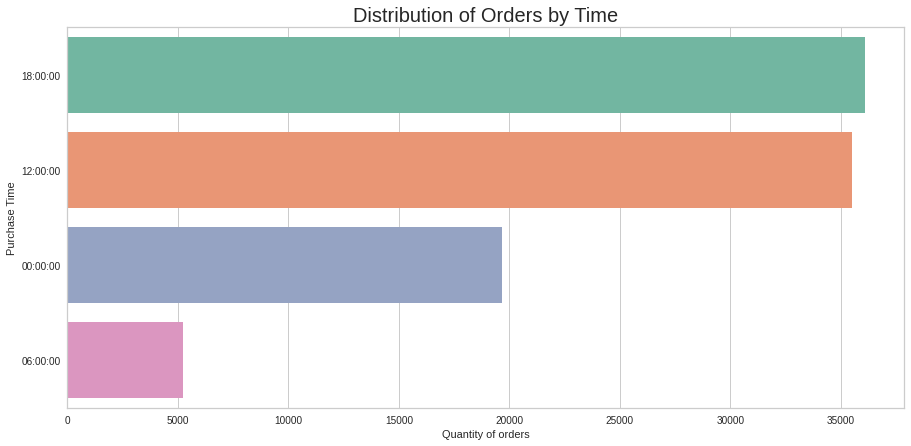

In [32]:
plt.figure(figsize=(15,7))
seasonality_time = data.groupby(['time_purchase'])['order_id'].nunique().sort_values(ascending=False).reset_index()
sns.barplot(y='time_purchase', x='order_id',data=seasonality_time, palette='Set2')
plt.title("Distribution of Orders by Time", fontsize=20)
plt.ylabel('Purchase Time')
plt.xlabel('Quantity of orders')

Berdasarkan grafik tersebut dapat terlihat bahwa pembelian cenderung meningkat pada siang hingga malam hari (jam 12:00 hingga diatas jam 18:00)

**Distribution of payment types by month**

In [33]:
total_influence_plots = data.groupby(['customer_id','payment_type','month_purchase','payment_installments','price'])['order_id'].nunique().sort_values(ascending=False).reset_index()
total_influence_plots = total_influence_plots.groupby(['customer_id','payment_type','month_purchase']).agg({'price':'sum','payment_installments':'sum'}).reset_index()
total_influence_plots.head()

,customer_id,payment_type,month_purchase,price,payment_installments
0,00012a2ce6f8dcda20d059ce98491703,credit_card,11,89.80,8.0
1,000161a058600d5901f007fab4c27140,credit_card,7,54.90,5.0
2,0001fd6190edaaf884bcaf3d49edf079,credit_card,2,179.99,10.0
3,0002414f95344307404f0ace7a26f1d5,ticket,8,149.90,1.0
4,000379cdec625522490c315e70c7a9fb,ticket,4,93.00,1.0


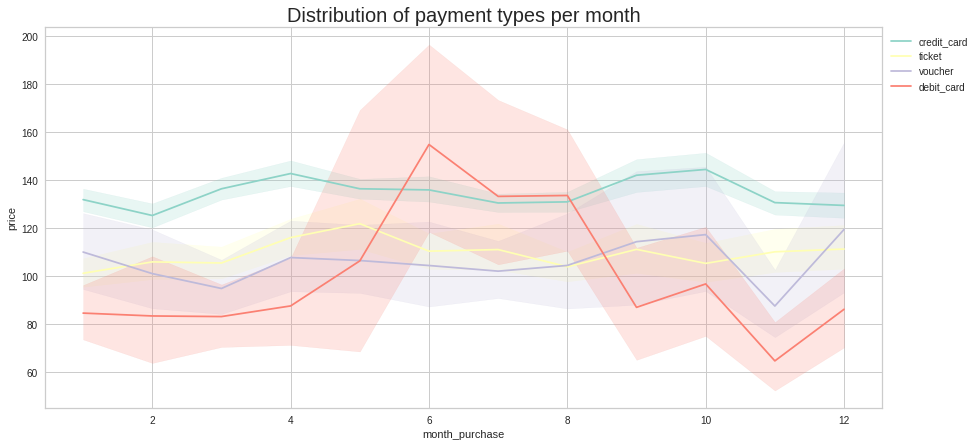

In [34]:
plt.figure(figsize=(15,7))

sns.lineplot(x='month_purchase',y='price', hue='payment_type', data= total_influence_plots , palette='Set3')

g.set_xlabel("Year", fontsize=14)
g.set_ylabel("Quantity of orders", fontsize=14)
plt.title("Distribution of payment types per month", fontsize=20)
plt.legend(bbox_to_anchor=(1.0, 1), loc=2);

Berdasarkan grafik tersebut secara keseluruhan terlihat bahwa penggunaan credit card cenderung stabil dan berada di atas metode pembayaran lainnya. Akan tetapi terjadi lonjakan penggunaan debit card secara tiba-tiba di bulan ke 6, hal ini bisa menjadi indikasi bahwa adanya strategi marketing untuk peningkatan penggunaan debit card yang berhasil pada periode tersebut. 

**Number of customers X Revenue**

In [35]:
sales_month= data_filter.groupby(['month_purchase','year_purchase']).agg({
    'price':'sum',
    'customer_id':'count'}).reset_index()
sales_month

,month_purchase,year_purchase,price,customer_id
0,1,2017,120037.59,961
1,1,2018,961101.67,8364
2,2,2017,244342.30,1949
3,2,2018,860867.82,7765
4,3,2017,381305.59,3078
5,3,2018,994744.41,8337
6,4,2017,361157.69,2707
7,4,2018,1006279.64,8112
8,5,2017,528278.78,4260
9,5,2018,1012647.65,8104


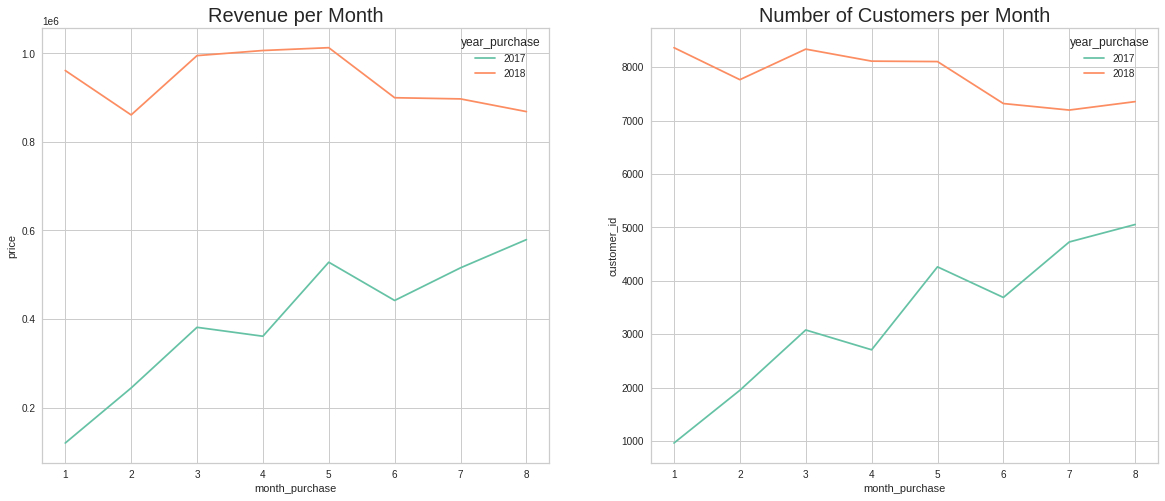

In [36]:
fig, axes = plt.subplots(1,2, figsize = (20,8))

sns.lineplot(x="month_purchase", y="price", hue='year_purchase',palette="Set2",
             data=sales_month, ax=axes[0])
axes[0].set_title("Revenue per Month", fontsize=20)

sns.lineplot(x="month_purchase", y="customer_id", hue='year_purchase',palette="Set2",
             data=sales_month, ax=axes[1])
axes[1].set_title("Number of Customers per Month",fontsize=20)

plt.show()


Grafik di atas menunjukkan bahwa jumlah total revenue yang dihasilkan selama periode 2017-2018 memiliki tingkat ketergantungan yang sebanding dengan jumlah pembelian yang dilakukan oleh pelanggan baru di Olist. Namun, menurut teori penjualan Kotler, kerugian kompetitif terjadi ketika keuntungan perusahaan bergantung pada masuknya pelanggan baru daripada loyalitas mereka. Pelanggan yang puas akan menjadi pendukung perusahaan. Dengan meningkatkan loyalitas pelanggan, perusahaan dapat melakukan penghematan sumber daya yang seharusnya dihabiskan untuk pemasaran dan dapat diinvestasikan dalam prioritas lain.

Mempertahankan pelanggan di perusahaan memberikan keuntungan dalam jangka menengah dan panjang. Oleh karena itu, masalah yang ingin kami pecahkan dengan analisis ini adalah mengelompokkan pelanggan sehingga kami dapat menentukan strategi yang dipersonalisasi untuk mempertahankan setiap kelompok pelanggan.

## **Cohort Analysis**

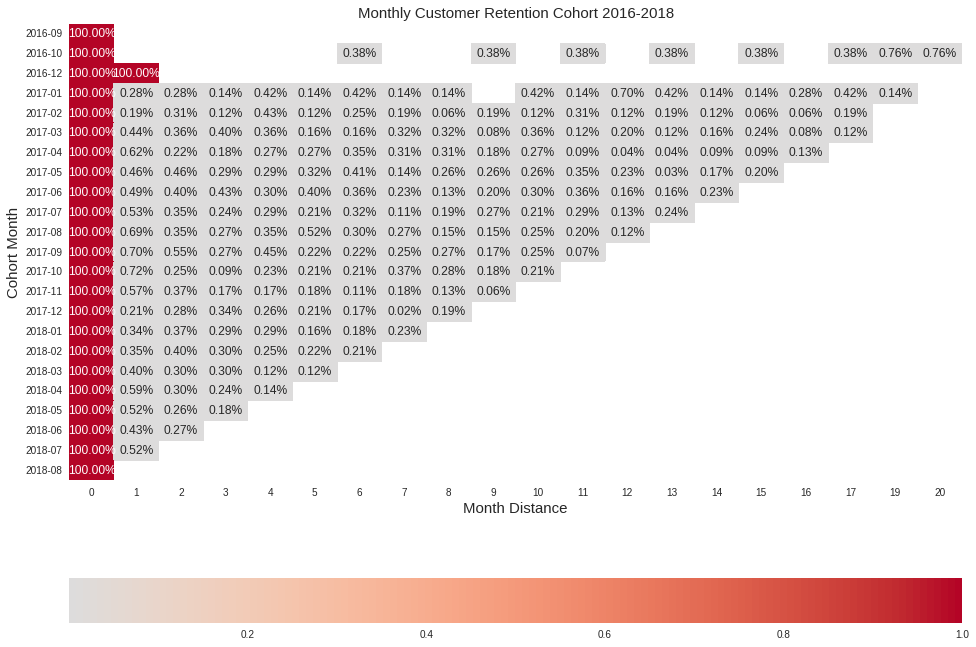

In [37]:
data['cohort_month'] = data.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
data['current_order_month']=data['order_purchase_timestamp'].dt.to_period('M')
data_cohort = data.groupby(['cohort_month','current_order_month']).agg(n_customer=('customer_unique_id','nunique')).reset_index()
data_cohort['period'] = (data_cohort['current_order_month'] - data_cohort['cohort_month']).apply(attrgetter('n'))
cohort_retention_pivot = data_cohort.pivot_table(
                                            index='cohort_month',
                                            columns='period',
                                            values='n_customer'
                                            ) 
cohort_size = cohort_retention_pivot.iloc[:, 0]
retention_in_percentage = cohort_retention_pivot.divide(cohort_size,axis=0)
plt.figure(figsize=(16,12))

sns.heatmap(
    data = retention_in_percentage, 
    annot = True,
    cmap = 'coolwarm', 
    center = 0,
    fmt = '.2%', 
    cbar_kws = {'orientation':'horizontal'}

)

plt.xlabel('Month Distance', size=15)
plt.ylabel('Cohort Month', size=15)
plt.title('Monthly Customer Retention Cohort 2016-2018',size=15),
plt.show()

Berdasarkan hasil cohort anaysis di atas terlihat bahwa kekhawatiran yang disebutkan sebelumnya bahwa top 10 categories orders product dapat mempengaruhi churn customer adalah benar adanya. Dapat dilihat bahwa terjadi penurunan yang sangat signifikan dari bulan ke bulan. Hal ini terjadi karena produk yang sering dibeli customer dalam Olist adalah produk-produk yang memiliki masa waktu pemakaian yang cukup lama. Hal ini dapat diatasi dengan melakukan market basket analysis. Namun dalam projek kami kali ini, market basket analysis bukanlah tujuan kami, oleh karena itu analisis tersebut tidak kami lakukan. Akan tetapi, market basket analysis dapat menjadi saran bagi pembaca yang ingin mengerjakan projek dataset Olist ini kedepannya.

## **Segmentation using RFM**

Istilah RFM berasal dari persimpangan tiga akronim: Pengkinian (Currency), Frekuensi, dan Moneteritas. Metode ini adalah cara perusahaan untuk dapat lebih memahami pelanggan dan memastikan kapan pembelian terakhirnya, berapa kali dia membeli dan seberapa banyak uang yang telah dihabiskan oleh customer tersebut.

Pengkinian(R) Hari sejak pembelian terakhir customer, Frekuensi(F) Jumlah produk yang dibeli oleh customer, Monetaritas(M) Total pengeluaran untuk pembelian.

Model RFM dapat digunakan untuk melakukan segmentasi perilaku pembelian customer, namun sebelum itu perlu adanya penentuan skor RFM.

Adapun penentuan skor ditentukan sebagai berikut:
Semakin baru pembelian pelanggan, semakin tinggi skor Kekinian (R). Semakin banyak pembelian yang dilakukan pelanggan, semakin tinggi skor Frekuensi (F). Semakin banyak pembelanjaan pelanggan untuk pembelian, semakin tinggi skor yang akan dimiliki pelanggan (M).

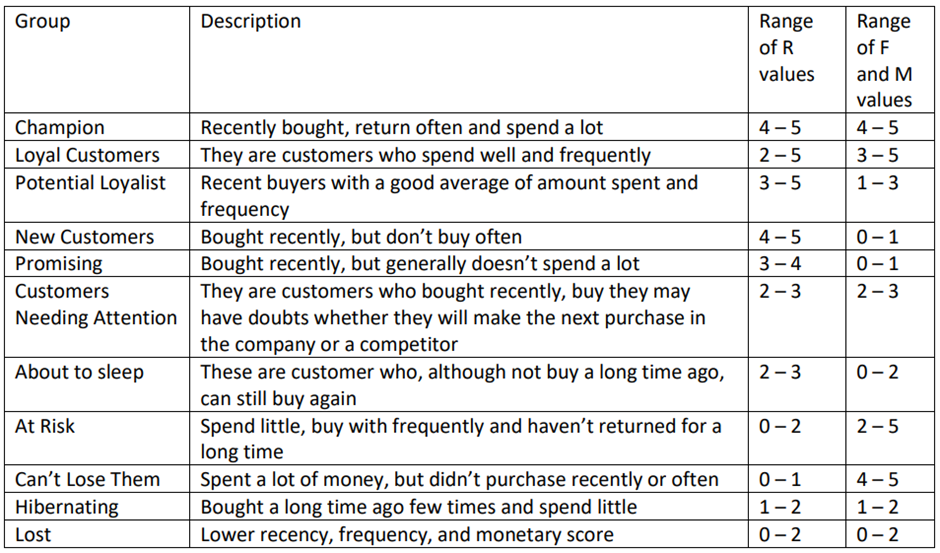

In [38]:
max_date = max(data['purchase_date']) + timedelta(days=1)

In [39]:
recurrence = data.groupby(['customer_unique_id','purchase_date','customer_id','price'])['order_id'].nunique().sort_values(ascending=False).reset_index()
recurrence = recurrence.groupby(['customer_unique_id']).agg({
    'purchase_date': lambda x: (max_date - x.max()).days,
    'customer_id':'count',
    'price':'sum'
}).reset_index()

# Pembelian terakhir dengan tanggal yang ada pada database, dan cek berapa lama transaksi terakhir dilakukan
# Dari tanggal ini. Contoh, transaksi terakhir - 112, pembelian ini telah di lakukan 112 hari sebelum tanggal transaksi terakhir
# yang ada di database

recurrence.columns =['customer_id','recency','frequency','monetary']
recurrence.sample(10)

# Frequency adalah jumlah berapa kali pelanggan yang sama melakukan transaksi di toko, tidak peduli berapa banyak kali

,customer_id,recency,frequency,monetary
60889,a6b38dcfe711532c6f588ca185770b2d,405,1,44.99
5510,0f0bf5903614594ea042384fa3c86770,143,1,19.00
79444,d99d9eec199e32dcde0efedc42a64724,484,1,75.00
29414,5076366c05f3f8a857f811397338c6ac,539,1,69.90
88269,f204f45d5fa1e9e2861fc425dc9016ea,449,1,20.00
50481,8a851617296124a4857303e40406411b,329,1,49.00
47742,82b73b7f618cd46925962c648ecf2875,180,1,148.00
44441,79b5958bf2a8f26e52d5df883768655d,288,1,54.90
93299,ffe76cb2f4bb39384c432d65ece67441,127,1,49.00
71313,c35a2c4f4bf555b012e91c179023750c,24,1,24.99


In [40]:
def get_segment(data):
  mean_fm = (data['F'] + data['M']) / 2
  if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 4 and mean_fm <= 5):
    return 'Champions'
  if (data['R'] >= 2 and data['R'] <= 5) and (mean_fm >= 3 and mean_fm <= 5):
      return 'Loyal Customers'
  if (data['R'] >= 3 and data['R'] <= 5) and (mean_fm >= 1 and mean_fm <= 3):
      return 'Potential Loyslist'
  if (data['R'] >= 4 and data['R'] <= 5) and (mean_fm >= 0 and mean_fm <= 1):
      return 'New Customers'
  if (data['R'] >= 3 and data['R'] <= 4) and (mean_fm >= 0 and mean_fm <= 1):
      return 'Promising'
  if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 2 and mean_fm <= 3):
      return 'Customer Needing Attention'
  if (data['R'] >= 2 and data['R'] <= 3) and (mean_fm >= 0 and mean_fm <= 2):
      return 'About to Sleep'
  if (data['R'] >= 0 and data['R'] <= 2) and (mean_fm >= 2 and mean_fm <= 5):
      return 'At Risk'
  if (data['R'] >= 0 and data['R'] <= 1) and (mean_fm >= 4 and mean_fm <= 5):
      return "Can't Lose Then"
  if (data['R'] >= 1 and data['R'] <= 2) and (mean_fm >= 1 and mean_fm <= 2):
      return 'Hibernating'
  return 'Lost'

In [41]:
recurrence.groupby(['frequency'])['customer_id'].nunique().sort_values(ascending=False).reset_index()

,frequency,customer_id
0,1,88437
1,2,4311
2,3,458
3,4,90
4,5,21
5,6,11
6,7,3
7,8,3
8,10,1
9,15,1


In [42]:
recurrence['R'] = pd.qcut(recurrence['recency'], 6, labels=[5, 4, 3, 2, 1, 0])
recurrence['F'] = recurrence['frequency'].apply(lambda x: 5 if x>=5 else x)  
recurrence['M'] = pd.qcut(recurrence['monetary'], 6, labels=[0, 1, 2, 3, 4, 5])

In [43]:
recurrence['segment'] = recurrence.apply(get_segment,axis=1)

In [44]:
recurrence.head(10)

,customer_id,recency,frequency,monetary,R,F,M,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,4,1,4,Potential Loyslist
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,4,1,0,New Customers
2,0000f46a3911fa3c0805444483337064,538,1,69.00,0,1,2,Lost
3,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,1,1,0,Lost
4,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,2,1,4,Customer Needing Attention
5,0004bd2a26a76fe21f786e4fbd80607f,147,1,154.00,4,1,4,Potential Loyslist
6,00050ab1314c0e55a6ca13cf7181fecf,132,1,27.99,4,1,0,New Customers
7,00053a61a98854899e70ed204dd4bafe,183,1,191.00,3,1,5,Loyal Customers
8,0005e1862207bf6ccc02e4228effd9a0,544,1,135.00,0,1,4,At Risk
9,0005ef4cd20d2893f0d9fbd94d3c0d97,171,1,104.90,3,1,3,Potential Loyslist


In [45]:
segmentwise = recurrence.groupby('segment').agg(RecencyMean = ('recency', 'mean'),
                                          FrequencyMean = ('frequency', 'mean'),
                                          MonetaryMean = ('monetary', 'mean'),
                                          GroupSize = ('recency', 'size'))
segmentwise

,RecencyMean,FrequencyMean,MonetaryMean,GroupSize
segment,,,,
About to Sleep,257.295637,1.009089,44.251032,7702
At Risk,418.252993,1.100874,224.164644,15455
Champions,76.642424,3.678788,424.826242,165
Customer Needing Attention,256.659183,1.042191,122.068817,5167
Hibernating,349.267131,1.011543,55.224091,5458
Lost,456.336060,1.008278,37.970835,10147
Loyal Customers,149.160011,1.221736,385.156521,10968
New Customers,74.933725,1.000000,22.252863,5100
Potential Loyslist,111.983216,1.027262,89.670641,30445


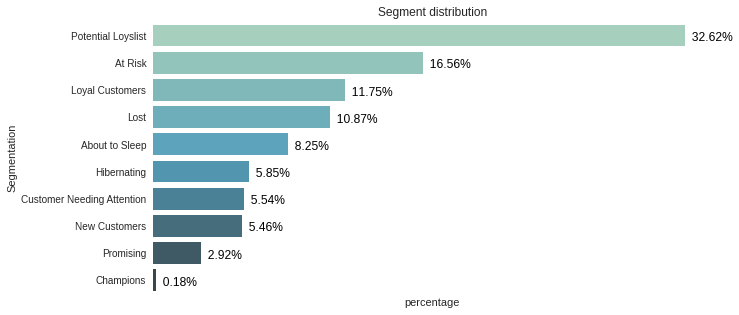

In [46]:
plt.figure(figsize=(10,5))
percentage = (recurrence['segment'].value_counts(normalize=True)* 100).reset_index(name='percentage')
g = sns.barplot(x=percentage['percentage'],y=percentage['index'], data=percentage,palette="GnBu_d")
sns.despine(bottom = True, left = True)
for i, v in enumerate(percentage['percentage']):
    g.text(v,i+0.20,"  {:.2f}".format(v)+"%", color='black', ha="left")
g.set_ylabel('Segmentation')
g.set(xticks=[])
plt.title('Segment distribution')
plt.show()

Berdasarkan hasil RFM analisis, kelompok segmentasi tertinggi customer Olist adalah Potential Loyaltist yaitu sebesar 32.62%. Artinya customer tersebut merupkan pembeli baru-baru ini dengan rata-rata jumlah uang yang dibelanjakan dan frekuensi baik.

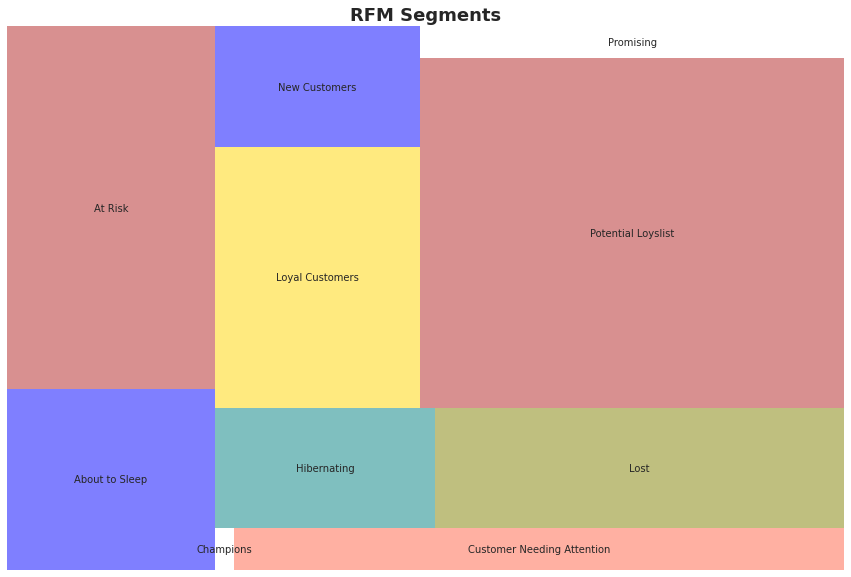

In [47]:
font = {'family' : 'Dejavu Sans',
        'weight' : 'normal',
        'size'   : 10}

plt.rc('font', **font)


fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(15, 10)
squarify.plot(sizes = segmentwise['GroupSize'], 
              label = segmentwise.index,
              color = ['blue','firebrick','white', 'tomato', 'teal', 'olive', 'gold'],
              alpha = 0.5)
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

## **Proposed Suggestions**

Sesuai dengan segmentasi yang diperlihatkan di atas, kami menyarankan beberapa strategi yang dapat dilakukan di masing-masing kelompok.

**32,62% Potensi Loyalist:** Grup ini terdiri dari pembeli baru-baru ini, yang memiliki frekuensi dan pembelanjaan rata-rata yang baik. Kelompok ini adalah grup dengan banyak potensi, karena customer yang memiliki pengalaman positif baru-baru ini dengan perusahaan mungkin akan tertarik untuk melakukan pembelian baru.

Strategi yang mungkin menarik:

Menawarkan program loyalitas atau voucher diskon; Pertahankan agar pelanggan potensial ini tetap terlibat dengan seller;

**16,56% At Risk:** Grup ini adalah kelompok pelanggan yang menghabiskan sedikit uang dan sering membeli, tetapi belakangan ini sudah lama tidak membeli. Grup ini perlu mendapat perhatian, karena merupakan segmen kedua dengan pelanggan terbanyak. Penting untuk mendapatkan kembali minat orang-orang ini di perusahaan. Grup ini menunjukkan sebagian pelanggan yang lama kelamaan kehilangan minat terhadap perusahaan. Oleh karena itu perusahaan perlu mendapatkan kembali perhatian dari kelompok customer ini.

Strategi yang mungkin menarik:

Mengirim komunikasi dan pesan yang dipersonalisasi untuk lebih dekat dengan pelanggan; Tawarkan penawaran bagus;

**11,75% Loyal Customer:** Grup ini adalah kelompok pelanggan yang berbelanja dengan baik dan sering Kelompok ini termasuk pelanggan yang sudah percaya pada perusahaan. Hubungan ini perlu dipertahankan agar berkembang menjadi lebih baru, dan mereka menjadi top customer.

Strategi yang mungkin menarik:

Komunikasi yang dipersonalisasi; Hindari mengirimkan penawaran massal (broadcast); Tawarkan sedikit promo, tetapi tunjukkan promo yang kemungkinan besar akan mereka minati; Menerapkan beberapa reward jika mereka memberikan ulasan setelah bertransaksi di Olist sehingga mereka bersedia mengungkapkan pengalaman positif mereka;

**10,87% Lost:** Grup ini adalah kelompok customer yang sudah lama tidak bertransaksi, memiliki frekuensi transaksi yang rendah, dan tidak banyak menghabiskan uang. 

Strategi yang mungkin menarik:

Menawarkan program loyalitas atau voucher diskon; Tunjukkan keunggulan yang ditawarkan perusahaan; Kampanye promosi untuk waktu yang terbatas, yang menciptakan sensasi yang tidak dapat dilewatkan;

**8,25% About To Sleep:** Grup ini adalah kelompok pelanggan yang meskipun sudah lama tidak membeli, masih bisa membeli lagi. Grup ini penting diperhatikan karena masih adanya potensi pembelian dari kelompok customer ini.

Strategi yang mungkin menarik:

Rekomendasi dan promosi terbatas sehingga dapat menarik perhatian customer untuk masuk kembali ke Olist; Komunikasi yang dipersonalisasi yang ditargetkan ke profil customer;

**5,85% Hibernating:** Grup ini adalah kelompok customer lama, namun hanya sekali atau beberapa kali bertransaksi dan hanya menghabiskan sedikit uangnya dalam bertransaksi. Kelompok ini perlu diperhatikan agar perusahaan menjadi menarik dimata customer kelompok ini, sehingga kelompok ini dapat berkembang menjadi loyal.

Strategi yang mungkin menarik:

Penawaran promo yang relevan; Komunikasi pengajuan penawaran;

**5,54% Customer Needing Attention:** Grup ini adalah kelompok customer yang baru saja melakukan transaksi di Olist, tetapi mungkin masih ragu apakah mereka akan melakukan transaksi berikutnya atau justru lebih baik bertransaksi di tempat lain (competitor). Kelompok ini membutuhkan tindakan agar mereka dapat merasakan bahwa perusahaan (Olist) dapat menawarkan kondisi terbaik dan memenuhi semua harapan mereka.

Strategi yang mungkin menarik:

Kampanye promosi untuk waktu yang terbatas, yang menciptakan sensasi yang tidak dapat dilewatkan; Tunjukkan keunggulan yang ditawarkan perusahaan;

**5,46% New Customer:** Grup ini terdiri dari kelompok customer yang baru-baru ini melakukan transaksi, namun sebenarnya mereka jarang bertransaksi atau transaksi mereka masih sedikit. Dalam kelompok ini dikategorikan sebagai customer baru, sehingga masih banyak pengembangan yang bisa dilakukan kepada kategori customer ini. Akan jauh lebih baik jika kategori customer ini dapat berkembang menjadi loyal customer atau bahkan Champion. 

Strategi yang mungkin menarik:

Menawarkan program loyalitas atau voucher diskon; Tunjukkan keunggulan yang ditawarkan perusahaan; 

**2,92% Promising:** Grup ini adalah kelompok customer yang baru-baru ini melakukan transaksi, namun frekuensi pembeliannya masih sedikit dan dalam menghabiskan uang kelompok ini juga masih sedikit.

Strategi yang mungkin menarik:

Menawarkan program loyalitas atau voucher diskon; Tunjukkan keunggulan yang ditawarkan perusahaan; 

**0.18% Champions:** Grup ini adalah kelompok pelanggan yang baru saja membeli, sering membeli, dan menghabiskan banyak uang. Mereka adalah top suctomer yang mendukung perusahaan. Hubungan baik antar Olist dan kelompok customer ini perlu dijaga agar tetap terjalin dengan baik.

Strategi yang mungkin menarik:

Penawaran khusus dan diskon khusus untuk pelanggan ini agar mereka merasa dihargai; Hindari mengirimkan penawaran massal (broadcast); Komunikasi yang dipersonalisasi; Hadiah; Meminta pendapat dan umpan balik untuk menunjukkan bahwa pendapatnya sebagai pelanggan penting;

**REFERENSI RFM**  https://medium.com/maxmilhas-tech/o-que-%C3%A9-rfm-e-como-aplic%C3%A1-lo-ao-seu-time-de-customer-service-b9c35817ed01

# __``Sellers Clustering``__

<hr>

## **Load Dataset**

In [48]:
products = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_products_dataset.csv")
products.rename(columns={'product_name_lenght':'product_name_length',
                         'product_description_lenght':'product_description_length'
                         },inplace=True) #just a typo correction
category_translation = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/product_category_name_translation.csv")
products = pd.merge(products, category_translation,how="left",
                    on="product_category_name")
products.drop(["product_category_name"], axis=1, inplace=True)
products = products.rename(columns={"product_category_name_english":
                                    "product_category_name"})
o_items = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_order_items_dataset.csv")
orders = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_orders_dataset.csv")
o_reviews = pd.read_csv('/content/drive/MyDrive/Alpha Engineering/olist_order_reviews_dataset.csv')
geoloc = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_geolocation_dataset.csv")
sellers = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_sellers_dataset.csv")
o_payments = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_order_payments_dataset.csv")
customers = pd.read_csv("/content/drive/MyDrive/Alpha Engineering/olist_customers_dataset.csv")

orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date)
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date)
o_reviews['review_creation_date'] = pd.to_datetime(o_reviews.review_creation_date)
o_reviews['review_answer_timestamp'] = pd.to_datetime(o_reviews.review_answer_timestamp)

orders['delivery_delay'] = orders.order_delivered_customer_date - orders.order_estimated_delivery_date
orders['delivery_delay'] = orders.delivery_delay.astype('timedelta64[D]')
o_reviews['delay_review_response'] = o_reviews.review_answer_timestamp - o_reviews.review_creation_date
o_reviews['delay_review_response'] = o_reviews.delay_review_response.astype('timedelta64[D]')

## **Data Preprocessing**

In [49]:
# Barang yang terjual oleh seller
df_items_sold  = o_items.merge(sellers[['seller_id']], 
                 how = 'inner', left_on = 'seller_id', right_on = 'seller_id')

df_items_sold.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,0188777fe321843a18be24a6e9aa1e53,1,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94
2,0191bbb5166d4b9a68df11797d5acfa9,1,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17


In [50]:
# Barang yang terjual dan review nya
df_items_reviewed = df_items_sold.merge(o_reviews[['order_id','review_score','delay_review_response']], 
                    how = 'inner', left_on = 'order_id', right_on = 'order_id')

df_items_reviewed.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5,1.0
1,0188777fe321843a18be24a6e9aa1e53,1,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94,5,3.0
2,0191bbb5166d4b9a68df11797d5acfa9,1,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17,5,3.0


In [51]:
# Tambahan payment value
df_sales = df_items_reviewed.merge(o_payments[['order_id','payment_value']], 
           how = 'outer', left_on = 'order_id', right_on = 'order_id')
df_sales.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19
1,0188777fe321843a18be24a6e9aa1e53,1.0,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94,5.0,3.0,65.84
2,0191bbb5166d4b9a68df11797d5acfa9,1.0,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17,5.0,3.0,153.07


In [52]:
# Tambah delivery delay
df_sales_with_delay = df_sales.merge(orders[['customer_id', 'order_id','delivery_delay', 'order_status']], 
           how = 'inner', left_on = 'order_id', right_on = 'order_id')
df_sales_with_delay.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id,delivery_delay,order_status
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,-9.0,delivered
1,0188777fe321843a18be24a6e9aa1e53,1.0,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94,5.0,3.0,65.84,dc573d2a61a467e5e2826c1729691859,-11.0,delivered
2,0191bbb5166d4b9a68df11797d5acfa9,1.0,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17,5.0,3.0,153.07,62b59a64eb786a96516229b7f3612c72,-15.0,delivered


In [53]:
df_sales_with_delay['delivery_delay'] = df_sales_with_delay['delivery_delay'].apply(lambda x : 0 if x < 0 else x)
df_sales_with_delay.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id,delivery_delay,order_status
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered
1,0188777fe321843a18be24a6e9aa1e53,1.0,436c8d57ff8d4aa254318e9bd9b48c83,48436dade18ac8b2bce089ec2a041202,2017-07-31 14:35:11,55.9,9.94,5.0,3.0,65.84,dc573d2a61a467e5e2826c1729691859,0.0,delivered
2,0191bbb5166d4b9a68df11797d5acfa9,1.0,ec02a5d380128f7a188e9ce8f3ddd832,48436dade18ac8b2bce089ec2a041202,2017-08-16 12:30:15,132.9,20.17,5.0,3.0,153.07,62b59a64eb786a96516229b7f3612c72,0.0,delivered


In [54]:
products.columns

Index(['product_id', 'product_name_length', 'product_description_length',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'product_category_name'],
      dtype='object')

In [55]:
df_product_desc = df_sales_with_delay.merge(products[['product_id','product_description_length','product_photos_qty']], 
           how = 'inner', left_on = 'product_id', right_on = 'product_id')
df_product_desc.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id,delivery_delay,order_status,product_description_length,product_photos_qty
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0


In [56]:
olist = df_product_desc

In [57]:
pd.set_option('display.max_columns', 500)
olist.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id,delivery_delay,order_status,product_description_length,product_photos_qty
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,5.0,3.0,75.07,30407a72ad8b3f4df4d15369126b20c9,0.0,delivered,598.0,4.0
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,5.0,3.0,72.19,91a792fef70ecd8cc69d3c7feb3d12da,0.0,delivered,598.0,4.0


In [58]:
olist.groupby("order_status").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False)   

,order_id
order_status,
delivered,95832
shipped,1031
canceled,444
invoiced,307
processing,295
unavailable,6
approved,2


In [59]:
olist = olist[olist.order_status=='delivered']
olist

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id,delivery_delay,order_status,product_description_length,product_photos_qty
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.90,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.90,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.90,16.17,5.0,3.0,75.07,30407a72ad8b3f4df4d15369126b20c9,0.0,delivered,598.0,4.0
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.90,13.29,5.0,3.0,72.19,91a792fef70ecd8cc69d3c7feb3d12da,0.0,delivered,598.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117327,fd607d0a02cb276bc764a15f80f0423f,2.0,02ad78835ec3f72e750d1dfa6a7e11b3,2a73cba571d90c694b7caca072ccf6ce,2018-08-02 02:24:15,171.39,19.35,5.0,2.0,381.48,fef79774a4f4ef014078bcb0b42d0cc5,0.0,delivered,1303.0,2.0
117328,fdaf98feac227eb978d8f33f36e0231d,1.0,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,2017-04-27 05:10:28,119.90,16.14,4.0,1.0,136.04,81ae83ce1a10af9f93fa3512bd9713b1,2.0,delivered,533.0,2.0
117329,fe68b52db13993f58175fa589125d345,1.0,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,4.0,1.0,225.21,94203a446c1b46b5ac95b0aaf7221804,0.0,delivered,1306.0,3.0
117330,ff701a7c869ad21de22a6994237c8a00,1.0,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,5.0,3.0,84.68,8f6d16c31abb30b7b4650272cb0014a3,0.0,delivered,242.0,1.0


In [60]:
olist.groupby("order_status").agg({"order_id": "nunique"}).\
sort_values('order_id', ascending=False)

,order_id
order_status,
delivered,95832


In [61]:
olist.isna().sum() 

order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
review_score                     0
delay_review_response            0
payment_value                    3
customer_id                      0
delivery_delay                   8
order_status                     0
product_description_length    1626
product_photos_qty            1626
dtype: int64

In [62]:
# Mengisi kolom yang kosong
olist['delivery_delay'] = olist['delivery_delay'].fillna(0)
olist['product_description_length'] = olist['product_description_length'].fillna(0)
olist['product_photos_qty'] = olist['product_photos_qty'].fillna(0)

In [63]:
olist.dropna()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id,delivery_delay,order_status,product_description_length,product_photos_qty
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.90,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.90,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.90,16.17,5.0,3.0,75.07,30407a72ad8b3f4df4d15369126b20c9,0.0,delivered,598.0,4.0
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.90,13.29,5.0,3.0,72.19,91a792fef70ecd8cc69d3c7feb3d12da,0.0,delivered,598.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117327,fd607d0a02cb276bc764a15f80f0423f,2.0,02ad78835ec3f72e750d1dfa6a7e11b3,2a73cba571d90c694b7caca072ccf6ce,2018-08-02 02:24:15,171.39,19.35,5.0,2.0,381.48,fef79774a4f4ef014078bcb0b42d0cc5,0.0,delivered,1303.0,2.0
117328,fdaf98feac227eb978d8f33f36e0231d,1.0,f739e9151702508b18f796c53005e5e9,d1aa1ec0839dcab73a6161130eb1f94a,2017-04-27 05:10:28,119.90,16.14,4.0,1.0,136.04,81ae83ce1a10af9f93fa3512bd9713b1,2.0,delivered,533.0,2.0
117329,fe68b52db13993f58175fa589125d345,1.0,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,4.0,1.0,225.21,94203a446c1b46b5ac95b0aaf7221804,0.0,delivered,1306.0,3.0
117330,ff701a7c869ad21de22a6994237c8a00,1.0,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,5.0,3.0,84.68,8f6d16c31abb30b7b4650272cb0014a3,0.0,delivered,242.0,1.0


In [64]:
olist.dropna(subset=['payment_value'], inplace=True)

In [65]:
olist.isna().sum()

order_id                      0
order_item_id                 0
product_id                    0
seller_id                     0
shipping_limit_date           0
price                         0
freight_value                 0
review_score                  0
delay_review_response         0
payment_value                 0
customer_id                   0
delivery_delay                0
order_status                  0
product_description_length    0
product_photos_qty            0
dtype: int64

In [66]:
olist = olist.merge(customers[['customer_id', 'customer_unique_id']],
                     how = 'inner', left_on = 'customer_id', right_on = 'customer_id')

In [67]:
olist = olist.merge(recurrence[['customer_id', 'R', 'F', 'M']],
                     how = 'inner', left_on = 'customer_unique_id', right_on = 'customer_id')
olist

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id_x,delivery_delay,order_status,product_description_length,product_photos_qty,customer_unique_id,customer_id_y,R,F,M
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0,871766c5855e863f6eccc05f988b23cb,871766c5855e863f6eccc05f988b23cb,1,1,2
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.90,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0,0fb8e3eab2d3e79d92bb3fffbb97f188,0fb8e3eab2d3e79d92bb3fffbb97f188,0,1,2
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.90,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0,3419052c8c6b45daf79c1e426f9e9bcb,3419052c8c6b45daf79c1e426f9e9bcb,4,1,2
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.90,16.17,5.0,3.0,75.07,30407a72ad8b3f4df4d15369126b20c9,0.0,delivered,598.0,4.0,e7c828d22c0682c1565252deefbe334d,e7c828d22c0682c1565252deefbe334d,1,1,2
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.90,13.29,5.0,3.0,72.19,91a792fef70ecd8cc69d3c7feb3d12da,0.0,delivered,598.0,4.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,0bb98ba72dcc08e95f9d8cc434e9a2cc,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114831,fd607d0a02cb276bc764a15f80f0423f,1.0,02ad78835ec3f72e750d1dfa6a7e11b3,2a73cba571d90c694b7caca072ccf6ce,2018-08-02 02:24:15,171.39,19.35,5.0,2.0,381.48,fef79774a4f4ef014078bcb0b42d0cc5,0.0,delivered,1303.0,2.0,c13401002a5f9b60befb4c720de50be0,c13401002a5f9b60befb4c720de50be0,5,1,4
114832,fd607d0a02cb276bc764a15f80f0423f,2.0,02ad78835ec3f72e750d1dfa6a7e11b3,2a73cba571d90c694b7caca072ccf6ce,2018-08-02 02:24:15,171.39,19.35,5.0,2.0,381.48,fef79774a4f4ef014078bcb0b42d0cc5,0.0,delivered,1303.0,2.0,c13401002a5f9b60befb4c720de50be0,c13401002a5f9b60befb4c720de50be0,5,1,4
114833,fe68b52db13993f58175fa589125d345,1.0,f4135cbdece8245560f7be179533797a,3fefda3299e6dfaea3466ef346a3571a,2017-08-17 02:55:27,209.00,16.21,4.0,1.0,225.21,94203a446c1b46b5ac95b0aaf7221804,0.0,delivered,1306.0,3.0,52a953541861bbb4b79b39df24e00243,52a953541861bbb4b79b39df24e00243,1,1,5
114834,ff701a7c869ad21de22a6994237c8a00,1.0,5ff4076c0f01eeba4f728c9e3fa2653c,3e35a8bb43569389d3cebef0ce820f69,2018-04-18 20:10:33,27.90,14.44,5.0,3.0,84.68,8f6d16c31abb30b7b4650272cb0014a3,0.0,delivered,242.0,1.0,ddb2249e0316d365ceae561c0f011bce,ddb2249e0316d365ceae561c0f011bce,4,1,0


**Encoding RFM**

In [68]:
R = olist['R'].unique()
R = list(R)

enc = OneHotEncoder(sparse = False)

olist[R] = enc.fit_transform(olist[['R']])

olist.rename(columns={
    0:'R0', 
    1:'R1', 
    2:'R2',
    3:'R3', 
    4:'R4', 
    5:'R5', 
}, inplace=True)

olist.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id_x,delivery_delay,order_status,product_description_length,product_photos_qty,customer_unique_id,customer_id_y,R,F,M,R1,R0,R4,R3,R2,R5
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0,871766c5855e863f6eccc05f988b23cb,871766c5855e863f6eccc05f988b23cb,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0,0fb8e3eab2d3e79d92bb3fffbb97f188,0fb8e3eab2d3e79d92bb3fffbb97f188,0,1,2,1.0,0.0,0.0,0.0,0.0,0.0
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0,3419052c8c6b45daf79c1e426f9e9bcb,3419052c8c6b45daf79c1e426f9e9bcb,4,1,2,0.0,0.0,0.0,0.0,1.0,0.0
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,5.0,3.0,75.07,30407a72ad8b3f4df4d15369126b20c9,0.0,delivered,598.0,4.0,e7c828d22c0682c1565252deefbe334d,e7c828d22c0682c1565252deefbe334d,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,5.0,3.0,72.19,91a792fef70ecd8cc69d3c7feb3d12da,0.0,delivered,598.0,4.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,0bb98ba72dcc08e95f9d8cc434e9a2cc,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0


In [69]:
F = olist['F'].unique()
R = list(R)

enc = OneHotEncoder(sparse = False)

olist[F] = enc.fit_transform(olist[['F']])

olist.rename(columns={
    1:'F1', 
    2:'F2',
    3:'F3', 
    4:'F4',
    5:'F5'  
}, inplace=True)

olist.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id_x,delivery_delay,order_status,product_description_length,product_photos_qty,customer_unique_id,customer_id_y,R,F,M,R1,R0,R4,R3,R2,R5,F1,F2,F5,F3,F4
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0,871766c5855e863f6eccc05f988b23cb,871766c5855e863f6eccc05f988b23cb,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0,0fb8e3eab2d3e79d92bb3fffbb97f188,0fb8e3eab2d3e79d92bb3fffbb97f188,0,1,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0,3419052c8c6b45daf79c1e426f9e9bcb,3419052c8c6b45daf79c1e426f9e9bcb,4,1,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,5.0,3.0,75.07,30407a72ad8b3f4df4d15369126b20c9,0.0,delivered,598.0,4.0,e7c828d22c0682c1565252deefbe334d,e7c828d22c0682c1565252deefbe334d,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,5.0,3.0,72.19,91a792fef70ecd8cc69d3c7feb3d12da,0.0,delivered,598.0,4.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,0bb98ba72dcc08e95f9d8cc434e9a2cc,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [70]:
M = olist['M'].unique()
M = list(M)

enc = OneHotEncoder(sparse = False)

olist[M] = enc.fit_transform(olist[['M']])

olist.rename(columns={
    0:'M0', 
    1:'M1', 
    2:'M2',
    3:'M3', 
    4:'M4',
    5:'M5'  
}, inplace=True)

olist.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,review_score,delay_review_response,payment_value,customer_id_x,delivery_delay,order_status,product_description_length,product_photos_qty,customer_unique_id,customer_id_y,R,F,M,R1,R0,R4,R3,R2,R5,F1,F2,F5,F3,F4,M2,M4,M1,M3,M5,M0
0,00010242fe8c5a6d1ba2dd792cb16214,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,5.0,1.0,72.19,3ce436f183e68e07877b285a838db11a,0.0,delivered,598.0,4.0,871766c5855e863f6eccc05f988b23cb,871766c5855e863f6eccc05f988b23cb,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,130898c0987d1801452a8ed92a670612,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,5.0,3.0,73.86,e6eecc5a77de221464d1c4eaff0a9b64,0.0,delivered,598.0,4.0,0fb8e3eab2d3e79d92bb3fffbb97f188,0fb8e3eab2d3e79d92bb3fffbb97f188,0,1,2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,532ed5e14e24ae1f0d735b91524b98b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,4.0,1.0,83.23,4ef55bf80f711b372afebcb7c715344a,0.0,delivered,598.0,4.0,3419052c8c6b45daf79c1e426f9e9bcb,3419052c8c6b45daf79c1e426f9e9bcb,4,1,2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,6f8c31653edb8c83e1a739408b5ff750,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,5.0,3.0,75.07,30407a72ad8b3f4df4d15369126b20c9,0.0,delivered,598.0,4.0,e7c828d22c0682c1565252deefbe334d,e7c828d22c0682c1565252deefbe334d,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7d19f4ef4d04461989632411b7e588b9,1.0,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,5.0,3.0,72.19,91a792fef70ecd8cc69d3c7feb3d12da,0.0,delivered,598.0,4.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,0bb98ba72dcc08e95f9d8cc434e9a2cc,1,1,2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [71]:
olist.describe()

,order_item_id,price,freight_value,review_score,delay_review_response,payment_value,delivery_delay,product_description_length,product_photos_qty,F,R1,R0,R4,R3,R2,R5,F1,F2,F5,F3,F4,M2,M4,M1,M3,M5,M0
count,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000,114836.000000
mean,1.194617,119.772438,19.974923,4.080506,2.583040,171.259756,0.671035,773.627164,2.175755,1.150563,0.164704,0.170173,0.165584,0.166350,0.167299,0.165889,0.883173,0.093342,0.016162,0.004398,0.002926,0.165192,0.166829,0.160646,0.167012,0.163868,0.176452
std,0.685775,181.437150,15.704520,1.347630,9.765087,263.787390,4.474114,652.312281,1.725903,0.470867,0.370915,0.375786,0.371708,0.372396,0.373245,0.371982,0.321216,0.290912,0.126100,0.066169,0.054013,0.371355,0.372825,0.367206,0.372988,0.370158,0.381206
min,1.000000,0.850000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,39.900000,13.077500,4.000000,1.000000,60.720000,0.000000,340.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,74.900000,16.280000,5.000000,1.000000,108.000000,0.000000,594.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,132.900000,21.150000,5.000000,3.000000,188.690000,0.000000,976.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,21.000000,6735.000000,409.680000,5.000000,518.000000,13664.080000,188.000000,3992.000000,20.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


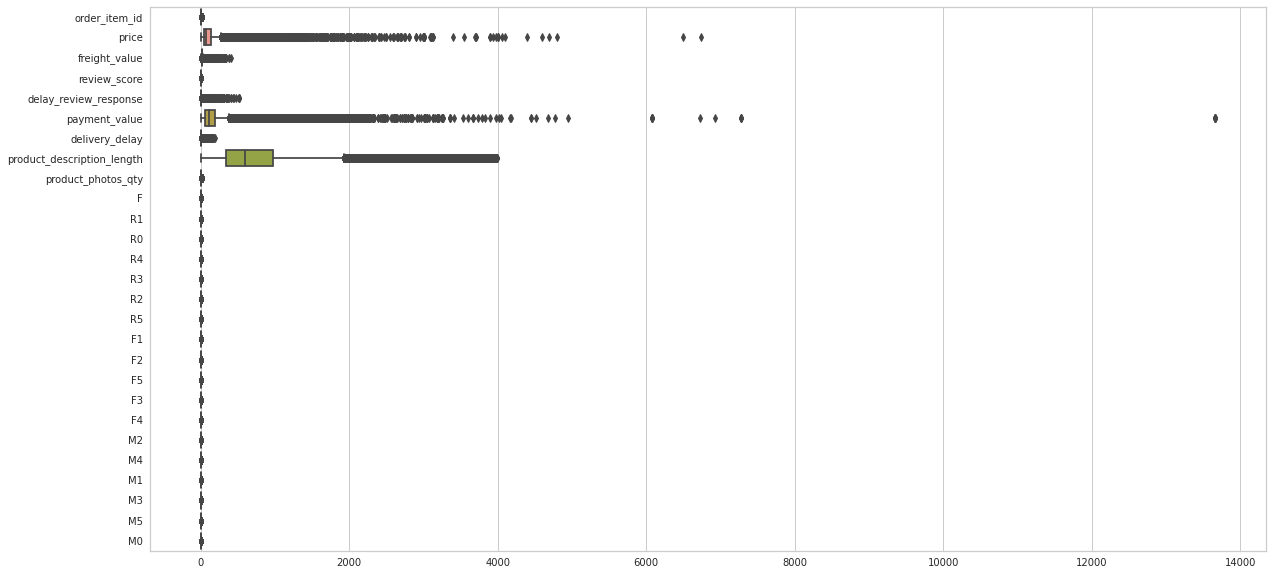

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'review_score',
       'delay_review_response', 'payment_value', 'customer_id_x',
       'delivery_delay', 'order_status', 'product_description_length',
       'product_photos_qty', 'customer_unique_id', 'customer_id_y', 'R', 'F',
       'M', 'R1', 'R0', 'R4', 'R3', 'R2', 'R5', 'F1', 'F2', 'F5', 'F3', 'F4',
       'M2', 'M4', 'M1', 'M3', 'M5', 'M0'],
      dtype='object')


In [72]:
plt.figure(figsize = (20,10))
sns.boxplot(data = olist, orient = "h")
plt.show()
print(olist.columns)

Ada beberapa outlier yang sangat berbeda jauh dengan data lainnya, sehingga perlu dilakukan drop outlier

In [73]:
olist.drop(olist.index[olist['payment_value'] >= 6000], inplace = True)

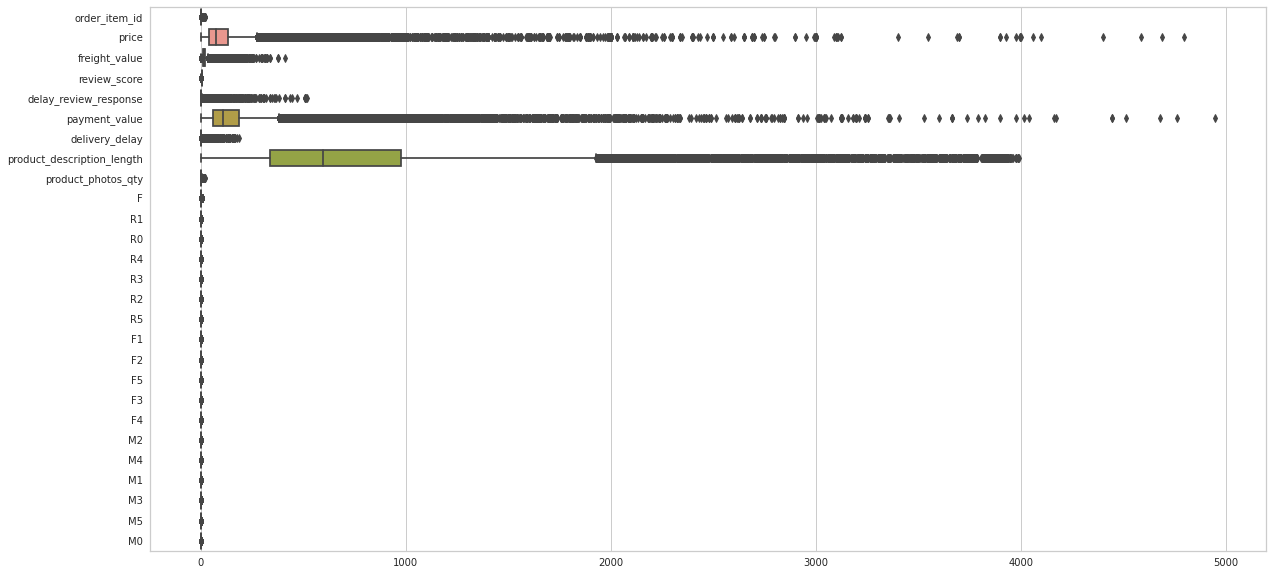

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'review_score',
       'delay_review_response', 'payment_value', 'customer_id_x',
       'delivery_delay', 'order_status', 'product_description_length',
       'product_photos_qty', 'customer_unique_id', 'customer_id_y', 'R', 'F',
       'M', 'R1', 'R0', 'R4', 'R3', 'R2', 'R5', 'F1', 'F2', 'F5', 'F3', 'F4',
       'M2', 'M4', 'M1', 'M3', 'M5', 'M0'],
      dtype='object')


In [74]:
plt.figure(figsize = (20,10))
sns.boxplot(data = olist, orient = "h")
plt.show()
print(olist.columns)

**Feature Engineering**

In [75]:
cluster_feature = olist.groupby('seller_id').agg({'order_id':'nunique', 
                                        'order_item_id' : 'sum',
                                        'payment_value':'mean',
                                        'review_score':'mean',
                                        'product_description_length':'mean',
                                        'product_photos_qty':'mean',
                                        'delivery_delay':'mean',
                                        'delay_review_response':'mean',
                                        'R0' : 'sum',
                                        'R1' : 'sum',
                                        'R2' : 'sum',
                                        'R3' : 'sum',
                                        'R4' : 'sum',
                                        'R5' : 'sum',
                                        'F1' : 'sum',
                                        'F2' : 'sum',
                                        'F3' : 'sum',
                                        'F4' : 'sum',
                                        'F5' : 'sum',
                                        'M0' : 'sum',
                                        'M1' : 'sum',
                                        'M2' : 'sum',
                                        'M3' : 'sum',
                                        'M4' : 'sum',
                                        'M5' : 'sum'
                                        # 'Hibernating': 'sum',
                                        # 'Lost': 'sum',
                                        # 'Potential Loyslist': 'sum',
                                        # 'At Risk' : 'sum',
                                        # 'Customer Needing Attention' : 'sum',
                                        # 'Loyal Customers': 'sum',
                                        # 'About to Sleep': 'sum',
                                        # 'Champions': 'sum',
                                        # 'Promising': 'sum',
                                        # 'New Customers': 'sum',
                                              })
cluster_feature

,order_id,order_item_id,payment_value,review_score,product_description_length,product_photos_qty,delivery_delay,delay_review_response,R0,R1,R2,R3,R4,R5,F1,F2,F3,F4,F5,M0,M1,M2,M3,M4,M5
seller_id,,,,,,,,,,,,,,,,,,,,,,,,,
0015a82c2db000af6aaaf3ae2ecb0532,3,3.0,916.020000,3.666667,849.000000,2.000000,0.000000,1.000000,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
001cca7ae9ae17fb1caed9dfb1094831,192,286.0,202.367811,3.974249,471.974249,1.789700,0.399142,2.150215,74.0,106.0,5.0,17.0,29.0,2.0,226.0,6.0,0.0,0.0,1.0,5.0,9.0,0.0,186.0,0.0,33.0
002100f778ceb8431b7a1020ff7ab48f,50,64.0,42.160862,4.086207,654.689655,1.000000,1.155172,1.655172,20.0,0.0,2.0,8.0,28.0,0.0,48.0,10.0,0.0,0.0,0.0,0.0,1.0,49.0,1.0,3.0,4.0
003554e2dce176b5555353e4f3555ac8,1,1.0,139.380000,5.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
004c9cd9d87a3c30c522c48c4fc07416,153,225.0,138.574039,4.128079,427.571429,0.852217,0.763547,3.078818,57.0,77.0,15.0,13.0,41.0,0.0,169.0,25.0,2.0,0.0,7.0,44.0,19.0,0.0,87.0,4.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffc470761de7d0232558ba5e786e57b7,27,35.0,74.454063,4.281250,835.937500,1.531250,0.500000,1.593750,0.0,0.0,14.0,7.0,0.0,11.0,29.0,2.0,0.0,0.0,1.0,1.0,4.0,15.0,5.0,6.0,1.0
ffdd9f82b9a447f6f8d4b91554cc7dd3,18,23.0,171.786667,4.285714,517.095238,1.190476,0.000000,2.380952,3.0,1.0,5.0,3.0,5.0,4.0,19.0,2.0,0.0,0.0,0.0,6.0,4.0,1.0,6.0,4.0,0.0
ffeee66ac5d5a62fe688b9d26f83f534,14,14.0,161.396429,4.214286,801.285714,4.928571,1.785714,1.785714,3.0,0.0,1.0,4.0,6.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13.0


**Cek Multicolinearitas**

In [76]:
columns_VIF = ['payment_value', 'review_score', 'product_description_length', 'product_photos_qty', 'delivery_delay', 'delay_review_response']

In [77]:
def calc_vif(df):
    vif = pd.DataFrame()
    vif['variable']= df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['Acceptable'] = np.where(vif.VIF < 4, 'yes', 'no')
    return(vif)

In [78]:
calc_vif(cluster_feature[columns_VIF])

,variable,VIF,Acceptable
0,payment_value,1.586495,yes
1,review_score,4.310645,no
2,product_description_length,3.096789,yes
3,product_photos_qty,3.227909,yes
4,delivery_delay,1.032334,yes
5,delay_review_response,1.127871,yes


Karena terdapat multicolinearity pada feature review_score, maka akan dilakukan drop untuk column tersebut.

In [79]:
cluster_feature.drop(columns = ['review_score'], axis = 1, inplace = True)

In [80]:
columns_VIF = ['payment_value', 'product_description_length', 'product_photos_qty', 'delivery_delay', 'delay_review_response']

In [81]:
def calc_vif(df):
    vif = pd.DataFrame()
    vif['variable']= df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['Acceptable'] = np.where(vif.VIF < 4, 'yes', 'no')
    return(vif)

In [82]:
calc_vif(cluster_feature[columns_VIF])

,variable,VIF,Acceptable
0,payment_value,1.550338,yes
1,product_description_length,2.443785,yes
2,product_photos_qty,2.323575,yes
3,delivery_delay,1.031872,yes
4,delay_review_response,1.091998,yes


## **KMEANS Clustering**

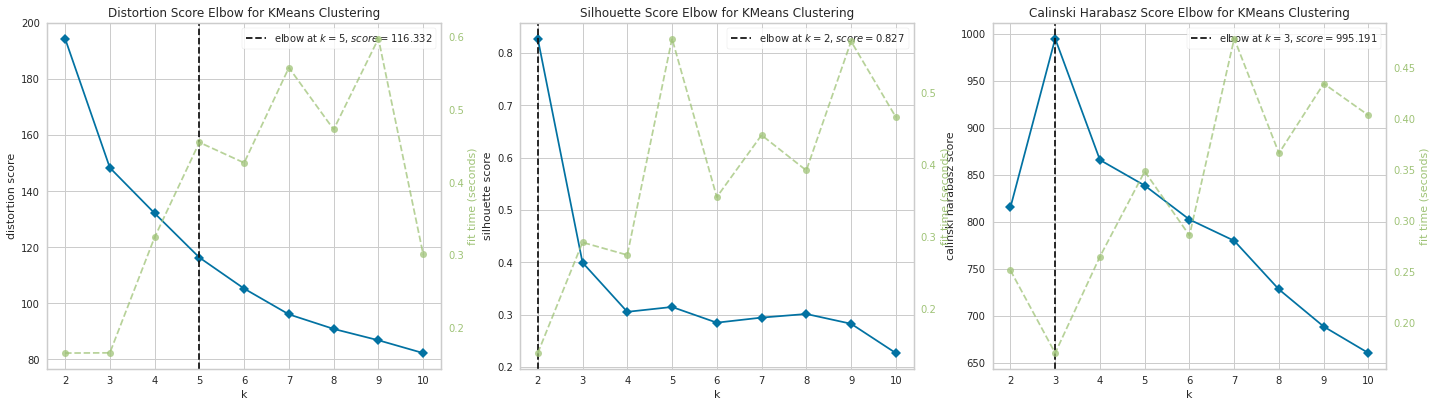

In [83]:
scaler = MinMaxScaler()

def Kmeansplots(data):
    X = data.copy()
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                          'uint8']).columns)
    preprocessor = ColumnTransformer([
        ('scaler', scaler, numerical_features)])

    plt.figure(figsize=(24, 14));ax1 = plt.subplot(2,3,1);ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    
    visual_grid1 = [
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='distortion',
                                      ax=ax1))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='silhouette',
                                      ax=ax2))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(KMeans(),K=(4,12),metric='calinski_harabasz',
                                      ax=ax3))]),'kelbowvisualizer')                    
                  ]

    i=0
    for viz in visual_grid1:
        viz[0].fit(X)
        if i==0:
          #Defining the best K by distortion method
          K = viz[0].named_steps['kelbowvisualizer'].elbow_value_ 
          i = i+1
        viz[0].named_steps[viz[1]].finalize()

    # KMeans Pipeline with best K
    kmeans_model = Pipeline([("preprocessor", preprocessor),
                            ("kmeans", KMeans(K,random_state=0))])
    kmeans_model.fit(X)
    # Kmeans labels
    kmeans_labels = kmeans_model.named_steps['kmeans'].labels_  
    X["kmeans_label"] = kmeans_labels

    return X

X_0 = Kmeansplots(cluster_feature)

In [84]:
Distortion_Kmeans_score = 116.290
Silhouette_Kmeans_score = 0.827
Calinski_Kmeans_score = 995.191
K_Kmeans = 5

In [85]:
X_0.groupby(['kmeans_label']).agg({'kmeans_label':'count',  
                                   'payment_value' : 'min',
                                   'product_description_length' : 'mean',
                                   'product_photos_qty' : 'mean',
                                   'delivery_delay' : 'max',
                                   'delay_review_response' : 'mean',
                                   'R0' : 'sum',
                                        'R1' : 'sum',
                                        'R2' : 'sum',
                                        'R3' : 'sum',
                                        'R4' : 'sum',
                                        'R5' : 'sum',
                                        'F1' : 'sum',
                                        'F2' : 'sum',
                                        'F3' : 'sum',
                                        'F4' : 'sum',
                                        'F5' : 'sum',
                                        'M0' : 'sum',
                                        'M1' : 'sum',
                                        'M2' : 'sum',
                                        'M3' : 'sum',
                                        'M4' : 'sum',
                                        'M5' : 'sum',
                                   })

,kmeans_label,payment_value,product_description_length,product_photos_qty,delivery_delay,delay_review_response,R0,R1,R2,R3,R4,R5,F1,F2,F3,F4,F5,M0,M1,M2,M3,M4,M5
kmeans_label,,,,,,,,,,,,,,,,,,,,,,,
0,457,21.510588,1946.250516,2.354480,35.000000,2.352634,1281.0,1535.0,1771.0,1576.0,1300.0,1950.0,8484.0,745.0,24.0,23.0,137.0,2760.0,1203.0,847.0,1647.0,1136.0,1820.0
1,1828,8.563333,567.177060,1.493466,44.666667,2.699655,5923.0,6433.0,7012.0,6098.0,5774.0,7734.0,34474.0,3607.0,159.0,162.0,572.0,6793.0,6317.0,7313.0,6106.0,6638.0,5807.0
2,13,38.333422,597.218639,2.344593,1.067845,2.502378,3854.0,2352.0,3336.0,3589.0,4277.0,2430.0,17479.0,1970.0,68.0,28.0,293.0,2357.0,4433.0,3206.0,3643.0,3248.0,2951.0
3,579,15.220000,827.905982,4.240980,167.000000,2.898762,2469.0,2206.0,2754.0,2419.0,2474.0,2911.0,13805.0,1186.0,40.0,30.0,172.0,2720.0,2451.0,1751.0,2680.0,2905.0,2726.0
4,86,35.047473,700.403185,1.858687,2.521951,2.587428,6007.0,6386.0,4339.0,5421.0,5184.0,4021.0,27158.0,3211.0,214.0,93.0,682.0,5613.0,4044.0,5853.0,5103.0,5231.0,5514.0


## **Agglomerative (Ward)**

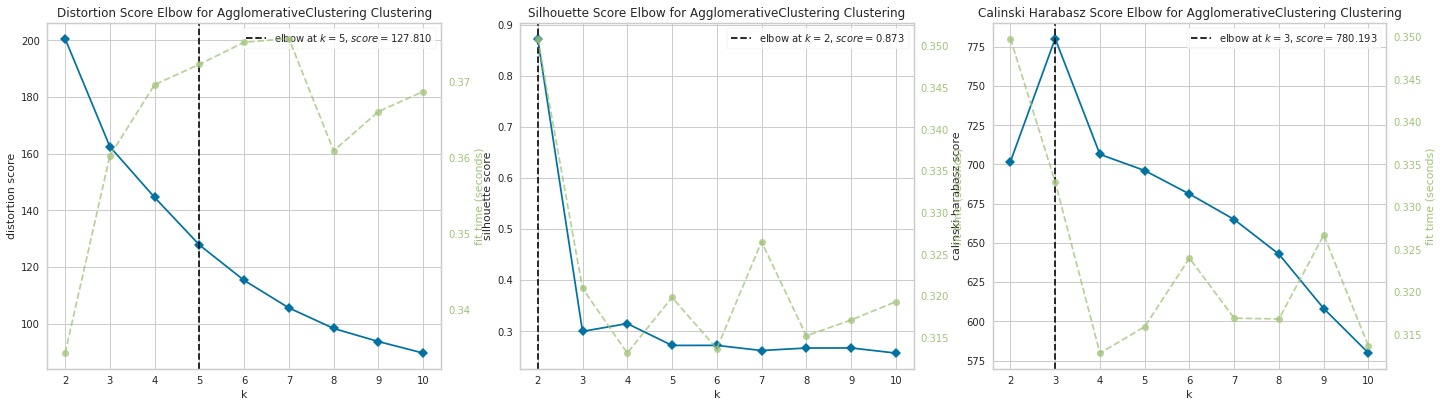

In [86]:
scaler = MinMaxScaler()

def AgglomerativeWard(data):
    X = data.copy()
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                          'uint8']).columns)
    preprocessor = ColumnTransformer([
        ('scaler', scaler, numerical_features)])

    plt.figure(figsize=(24, 14));ax1 = plt.subplot(2,3,1);ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    
    visual_grid1 = [
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(),K=(4,12),metric='distortion',
                                      ax=ax1))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(),K=(4,12),metric='silhouette',
                                      ax=ax2))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(),K=(4,12),metric='calinski_harabasz',
                                      ax=ax3))]),'kelbowvisualizer')                    
                  ]

    i=0
    for viz in visual_grid1:
        viz[0].fit(X)
        if i==0:
          #Defining the best K by distortion method
          K = viz[0].named_steps['kelbowvisualizer'].elbow_value_ 
          i = i+1
        viz[0].named_steps[viz[1]].finalize()

X_1 = AgglomerativeWard(cluster_feature)

In [87]:
Distortion_Ward_score = 127.810
Silhouette_Ward_score = 0.873
Calinski_Ward_score = 780.193
K_Ward = 5

## **Agglomerative (Average)**

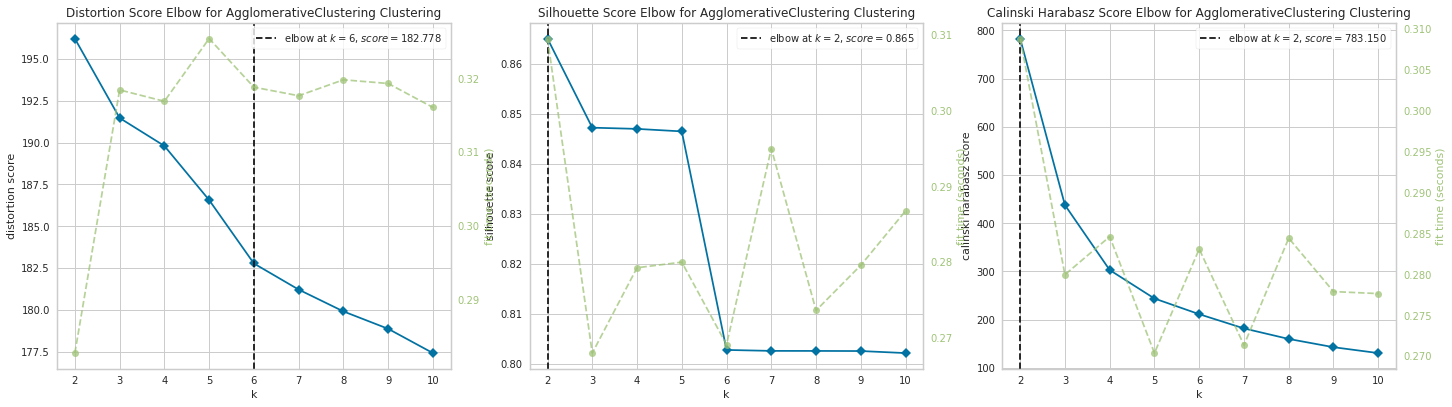

In [88]:
scaler = MinMaxScaler()

def AgglomerativeAverage(data):
    X = data.copy()
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                          'uint8']).columns)
    preprocessor = ColumnTransformer([
        ('scaler', scaler, numerical_features)])

    plt.figure(figsize=(24, 14));ax1 = plt.subplot(2,3,1);ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    
    visual_grid1 = [
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(linkage='average'),K=(4,12),metric='distortion',
                                      ax=ax1))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(linkage='average'),K=(4,12),metric='silhouette',
                                      ax=ax2))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(linkage='average'),K=(4,12),metric='calinski_harabasz',
                                      ax=ax3))]),'kelbowvisualizer')                    
                  ]

    i=0
    for viz in visual_grid1:
        viz[0].fit(X)
        if i==0:
          #Defining the best K by distortion method
          K = viz[0].named_steps['kelbowvisualizer'].elbow_value_ 
          i = i+1
        viz[0].named_steps[viz[1]].finalize()

X_2 = AgglomerativeAverage(cluster_feature)

In [89]:
Distortion_Average_score = 182.778
Silhouette_Average_score = 0.865
Calinski_Average_score = 783.150
K_Average = 6

## **Agglomerative (Complete)**

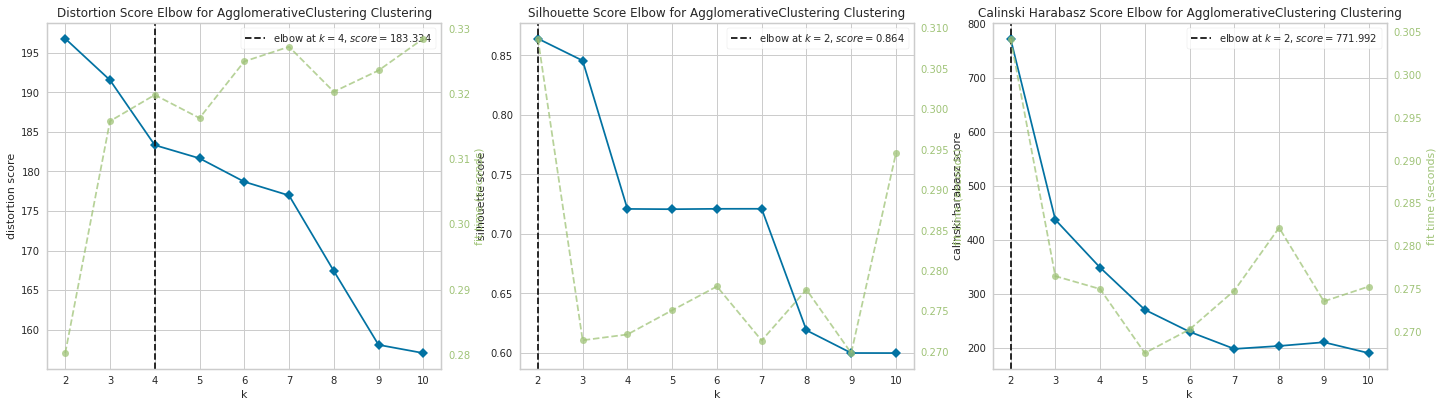

In [90]:
scaler = MinMaxScaler()

def AgglomerativeComplete(data):
    X = data.copy()
    numerical_features = list(data.select_dtypes(include=['int64','float64',
                                                          'uint8']).columns)
    preprocessor = ColumnTransformer([
        ('scaler', scaler, numerical_features)])

    plt.figure(figsize=(24, 14));ax1 = plt.subplot(2,3,1);ax2 = plt.subplot(2,3,2)
    ax3 = plt.subplot(2,3,3)
    
    visual_grid1 = [
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(linkage='complete'),K=(4,12),metric='distortion',
                                      ax=ax1))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(linkage='complete'),K=(4,12),metric='silhouette',
                                      ax=ax2))]),'kelbowvisualizer'),
                    (Pipeline([("preprocessor", preprocessor),("kelbowvisualizer"
                    , KElbowVisualizer(AgglomerativeClustering(linkage='complete'),K=(4,12),metric='calinski_harabasz',
                                      ax=ax3))]),'kelbowvisualizer')                    
                  ]

    i=0
    for viz in visual_grid1:
        viz[0].fit(X)
        if i==0:
          #Defining the best K by distortion method
          K = viz[0].named_steps['kelbowvisualizer'].elbow_value_ 
          i = i+1
        viz[0].named_steps[viz[1]].finalize()

X_3 = AgglomerativeComplete(cluster_feature)

In [91]:
Distortion_Complete_score = 183.334
Silhouette_Complete_score = 0.864
Calinski_Complete_score = 771.992
K_Complete = 4

## **DBSCAN**

In [92]:
scaler = MinMaxScaler()
cluster_feature_scaled = scaler.fit_transform(cluster_feature)

cluster_feature_scaled = pd.DataFrame(cluster_feature_scaled, columns = ['order_id', 'order_item_id',
                                                                         'payment_value', 'product_description_length',
                                                                         'product_photos_qty', 'delivery_delay', 'delay_review_response', 
                                                                         'R0','R1', 'R2', 'R3', 'R4' ,'R5' , 'F1','F2','F3',
                                                                         'F4','F5','M0','M1','M2','M3','M4','M5'
                                                                         ])
cluster_feature_scaled

,order_id,order_item_id,payment_value,product_description_length,product_photos_qty,delivery_delay,delay_review_response,R0,R1,R2,R3,R4,R5,F1,F2,F3,F4,F5,M0,M1,M2,M3,M4,M5
0,0.001109,0.000670,0.252499,0.212675,0.142857,0.000000,0.003311,0.005386,0.000000,0.000000,0.000000,0.000000,0.000000,0.001656,0.000000,0.000000,0.0,0.000000,0.005929,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.105876,0.095509,0.053926,0.118230,0.127836,0.002390,0.007120,0.132855,0.195572,0.009225,0.043814,0.051786,0.003656,0.124724,0.020408,0.000000,0.0,0.015873,0.009881,0.011364,0.000000,0.193146,0.000000,0.055276
2,0.027162,0.021113,0.009348,0.164000,0.071429,0.006917,0.005481,0.035907,0.000000,0.003690,0.020619,0.050000,0.000000,0.026490,0.034014,0.000000,0.0,0.000000,0.000000,0.001263,0.052859,0.001038,0.002947,0.006700
3,0.000000,0.000000,0.036400,0.000000,0.000000,0.000000,0.003311,0.000000,0.000000,0.000000,0.000000,0.001786,0.000000,0.000552,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001675
4,0.084257,0.075067,0.036175,0.107107,0.060873,0.004572,0.010195,0.102334,0.142066,0.027675,0.033505,0.073214,0.000000,0.093267,0.085034,0.064516,0.0,0.111111,0.086957,0.023990,0.000000,0.090343,0.003929,0.082077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958,0.014412,0.011394,0.018334,0.209403,0.109375,0.002994,0.005277,0.000000,0.000000,0.025830,0.018041,0.000000,0.020110,0.016004,0.006803,0.000000,0.0,0.015873,0.001976,0.005051,0.016181,0.005192,0.005894,0.001675
2959,0.009424,0.007373,0.045417,0.129533,0.085034,0.000000,0.007884,0.005386,0.001845,0.009225,0.007732,0.008929,0.007313,0.010486,0.006803,0.000000,0.0,0.000000,0.011858,0.005051,0.001079,0.006231,0.003929,0.000000
2960,0.007206,0.004357,0.042526,0.200723,0.352041,0.010693,0.005913,0.005386,0.000000,0.001845,0.010309,0.010714,0.000000,0.007726,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.001038,0.000000,0.021776
2961,0.030488,0.020777,0.054333,0.112622,0.184729,0.003717,0.012160,0.021544,0.000000,0.023985,0.036082,0.019643,0.014625,0.026490,0.030612,0.032258,0.0,0.000000,0.043478,0.002525,0.000000,0.014538,0.006876,0.021776


In [93]:
sil = []
score = 0

for eps in [i/10 for i in range(2, 10)]:  # [0.2, 0.3, 0.4, 0.5]
    
    for min_sample in range(2, 8): # [4, 5, 6, 7]

        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(cluster_feature_scaled)
        silhouette = silhouette_score(cluster_feature_scaled, labels)
        
        if score < silhouette:
            best_eps = eps
            best_sam = min_sample
            score = silhouette

        print(f'cluster present: {np.unique(labels)}, cluster size: {np.bincount(labels+1)}')
        # print(f'cluster size: {np.bincount(labels+1)}')
        print(f'    eps = {eps}, min_sample = {min_sample}, silhoutte score: {silhouette}')

        sil.append(silhouette)

print(f'best score: {score}, eps:{best_eps}, min_sample:{best_sam}')

cluster present: [-1  0], cluster size: [ 102 2861]
    eps = 0.2, min_sample = 2, silhoutte score: 0.6834456956688386
cluster present: [-1  0], cluster size: [ 102 2861]
    eps = 0.2, min_sample = 3, silhoutte score: 0.6834456956688386
cluster present: [-1  0  1], cluster size: [ 103 2855    5]
    eps = 0.2, min_sample = 4, silhoutte score: 0.44959172092226785
cluster present: [-1  0  1], cluster size: [ 104 2854    5]
    eps = 0.2, min_sample = 5, silhoutte score: 0.4498116886442374
cluster present: [-1  0  1], cluster size: [ 112 2844    7]
    eps = 0.2, min_sample = 6, silhoutte score: 0.641300343894925
cluster present: [-1  0], cluster size: [ 121 2842]
    eps = 0.2, min_sample = 7, silhoutte score: 0.6706548135795943
cluster present: [-1  0  1], cluster size: [  52 2909    2]
    eps = 0.3, min_sample = 2, silhoutte score: 0.561015403591859
cluster present: [-1  0], cluster size: [  54 2909]
    eps = 0.3, min_sample = 3, silhoutte score: 0.7615300628389509
cluster present: 

In [94]:
# Fit DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=2)
labels = dbscan.fit_predict(cluster_feature_scaled)
labels

array([ 0, -1,  0, ...,  0,  0,  0])

In [95]:
print('Silhouette score DBScan:', silhouette_score(cluster_feature_scaled, labels))

Silhouette score DBScan: 0.6834456956688386


In [96]:
cluster_feature_scaled['DBScan'] = dbscan.labels_
cluster_feature_scaled.head(10)

,order_id,order_item_id,payment_value,product_description_length,product_photos_qty,delivery_delay,delay_review_response,R0,R1,R2,R3,R4,R5,F1,F2,F3,F4,F5,M0,M1,M2,M3,M4,M5,DBScan
0,0.001109,0.000670,0.252499,0.212675,0.142857,0.000000,0.003311,0.005386,0.000000,0.000000,0.000000,0.000000,0.000000,0.001656,0.000000,0.000000,0.000000,0.000000,0.005929,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0.105876,0.095509,0.053926,0.118230,0.127836,0.002390,0.007120,0.132855,0.195572,0.009225,0.043814,0.051786,0.003656,0.124724,0.020408,0.000000,0.000000,0.015873,0.009881,0.011364,0.000000,0.193146,0.000000,0.055276,-1
2,0.027162,0.021113,0.009348,0.164000,0.071429,0.006917,0.005481,0.035907,0.000000,0.003690,0.020619,0.050000,0.000000,0.026490,0.034014,0.000000,0.000000,0.000000,0.000000,0.001263,0.052859,0.001038,0.002947,0.006700,0
3,0.000000,0.000000,0.036400,0.000000,0.000000,0.000000,0.003311,0.000000,0.000000,0.000000,0.000000,0.001786,0.000000,0.000552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001675,0
4,0.084257,0.075067,0.036175,0.107107,0.060873,0.004572,0.010195,0.102334,0.142066,0.027675,0.033505,0.073214,0.000000,0.093267,0.085034,0.064516,0.000000,0.111111,0.086957,0.023990,0.000000,0.090343,0.003929,0.082077,0
5,0.006652,0.018097,0.030990,0.123545,0.159341,0.004376,0.002929,0.000000,0.000000,0.031365,0.018041,0.000000,0.003656,0.009934,0.000000,0.000000,0.380952,0.000000,0.000000,0.008838,0.009709,0.009346,0.000000,0.001675,0
6,0.000000,0.000000,0.028247,0.161824,0.071429,0.000000,0.003311,0.000000,0.001845,0.000000,0.000000,0.000000,0.000000,0.000552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001038,0.000000,0.000000,0
7,0.000000,0.000000,0.035765,0.073397,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.002577,0.000000,0.000000,0.000552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001038,0.000000,0.000000,0
8,0.073725,0.086796,0.052487,0.121096,0.077508,0.004555,0.005812,0.034111,0.000000,0.031365,0.162371,0.148214,0.010969,0.087196,0.098639,0.000000,0.047619,0.000000,0.057312,0.044192,0.000000,0.069574,0.003929,0.088777,0
9,0.055987,0.065013,0.052943,0.159898,0.071429,0.001444,0.006153,0.000000,0.000000,0.029520,0.322165,0.000000,0.000000,0.055740,0.091837,0.000000,0.000000,0.206349,0.031621,0.022727,0.000000,0.079958,0.000000,0.050251,-1


In [97]:
cluster_feature_scaled.groupby(['DBScan']).agg({'DBScan':'count'})

,DBScan
DBScan,
-1,102
0,2861


Clustering dengan menggunakan DBScan tidak disarankan untuk digunakan pada dataset ini. Karena berdasarkan hasil clusteringnya, persebaran yang dihasilkan tidak menyebar dengan cukup baik.

## **Model Evaluation**

In [98]:
Kmeans_score = [Distortion_Kmeans_score, Silhouette_Kmeans_score, Calinski_Kmeans_score, K_Kmeans]
Ward_score = [Distortion_Ward_score, Silhouette_Ward_score, Calinski_Ward_score, K_Ward]
Average_score = [Distortion_Average_score, Silhouette_Average_score, Calinski_Average_score, K_Average]
Complete_score = [Distortion_Complete_score, Silhouette_Complete_score, Calinski_Complete_score, K_Complete]

In [99]:
evaluation = [Kmeans_score, Ward_score, Average_score, Complete_score]
model_evaluation = pd.DataFrame(evaluation, index = 'KMeans Ward Average Compete'.split(), 
                   columns = 'Distortion Silhouette Calinski Cluster'.split())

model_evaluation

,Distortion,Silhouette,Calinski,Cluster
KMeans,116.290,0.827,995.191,5
Ward,127.810,0.873,780.193,5
Average,182.778,0.865,783.150,6
Compete,183.334,0.864,771.992,4


In [100]:
# Persebaran cluster
X_0.groupby(['kmeans_label']).agg({'kmeans_label':'count'})

,kmeans_label
kmeans_label,
0,457
1,1828
2,13
3,579
4,86


Berdasarkan hasil evaluasi model, terlihat bahwa KMeans adalah model terbaik untuk melakukan clustering terhadap dataset yang kami gunakan. Hal ini karena distortion score KMeans adalah yang paling rendah dan calinski score KMeans adalah yang tertinggi. Sedangkan silhouette score KMeans cenderung standar (tidak terlalu tinggi maupun terlalu rendah). Kemudian jika dilihat dari jumlah cluster yang dihasilkan oleh KMeans, yaitu 5 cluster, menunjukan hasil yang cukup baik karena hasil cluster tidak terlalu sedikit maupun terlalu banyak. Jika dilihat dari persebaran cluster-nya model KMeans juga menunjukan hasil yang cukup baik.

## **Recomendation**

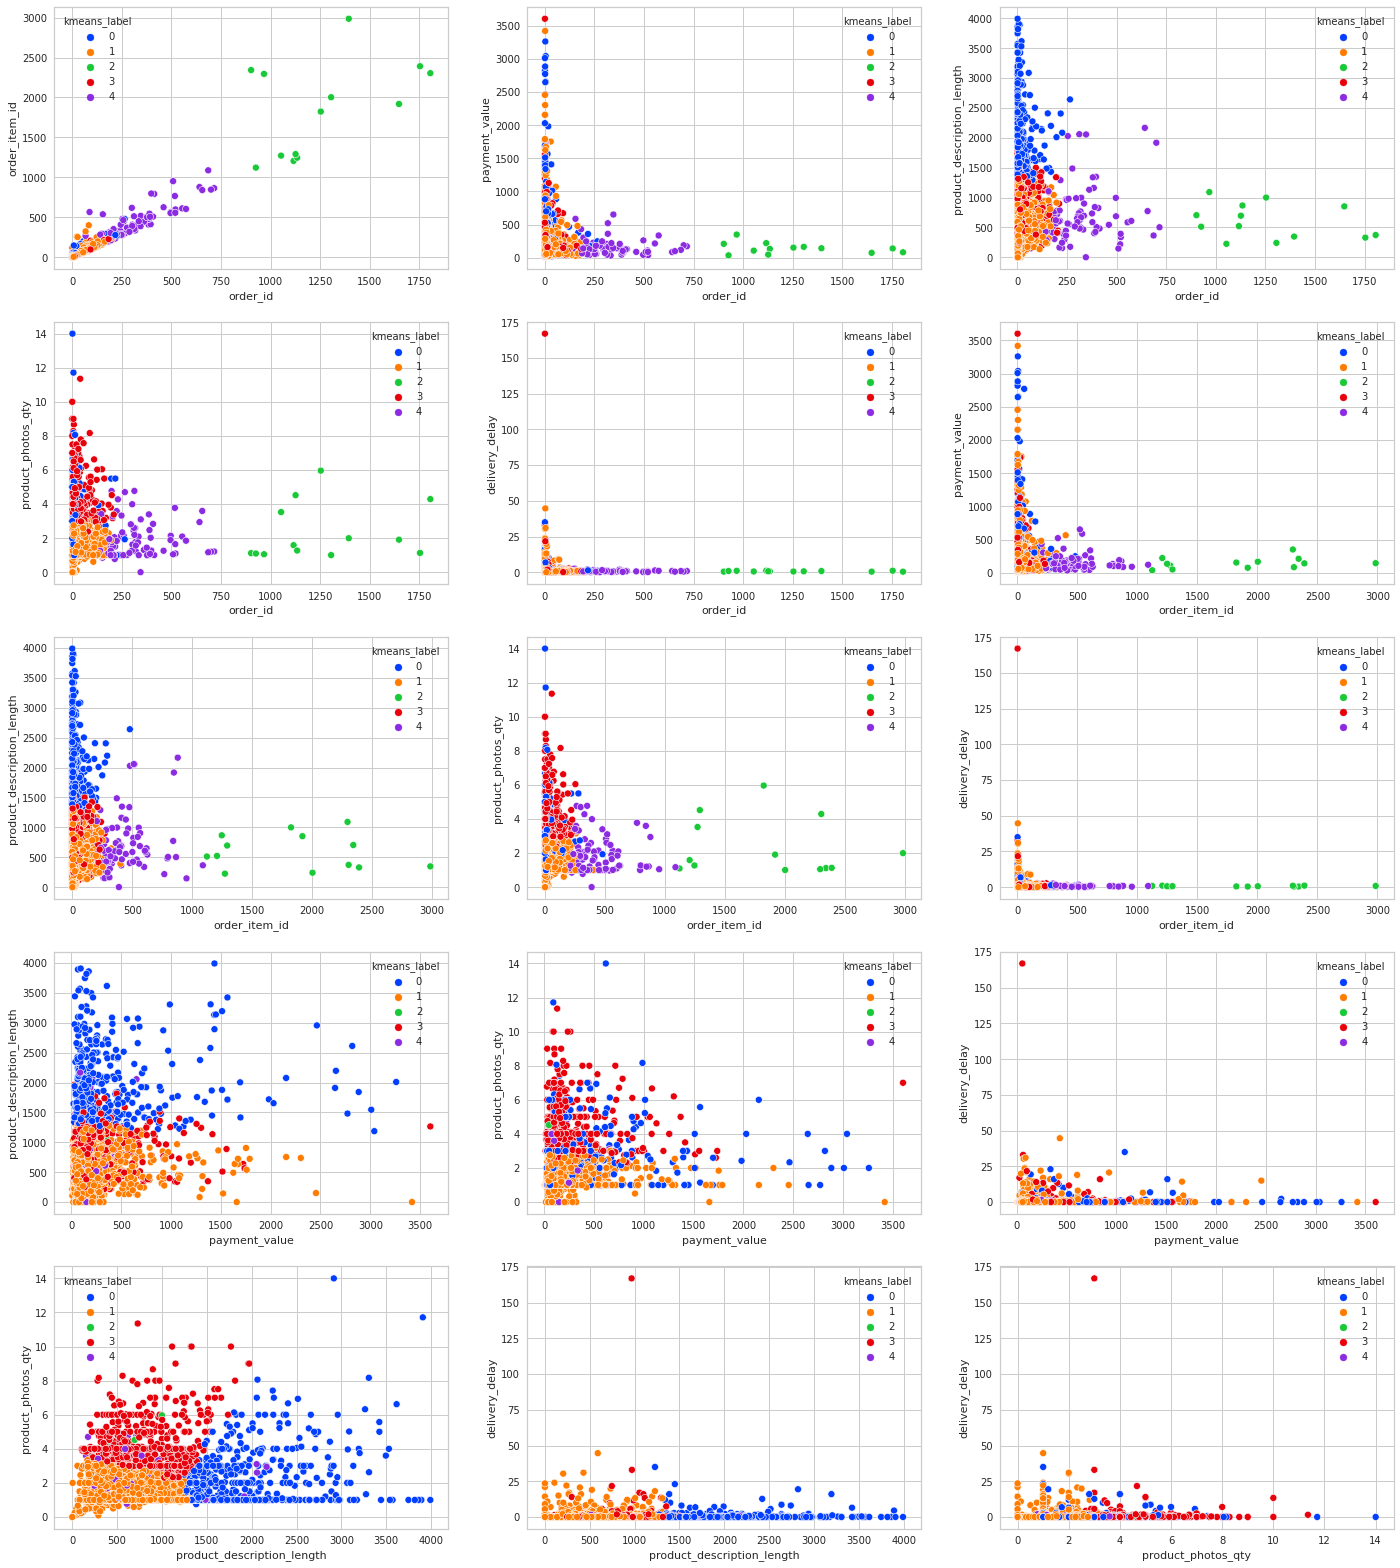

In [101]:
sum_of_columns = X_0.columns
fig = plt.figure(figsize=(24,28))
a = 0; b = 0; c = 1
for i in sum_of_columns[0:6]:
    for j in sum_of_columns[c:6]:
        if i == j:
            continue
        axes = plt.subplot2grid((5,3),(a,b))
        sns.scatterplot(x = X_0[i],y = X_0[j],hue='kmeans_label', data=X_0, palette='bright', ax = axes)
        axes.yaxis.grid(True)
        axes.xaxis.grid(True)
        b = b+1
        if b>=3:
            b = 0
            a = a+1
    c += 1

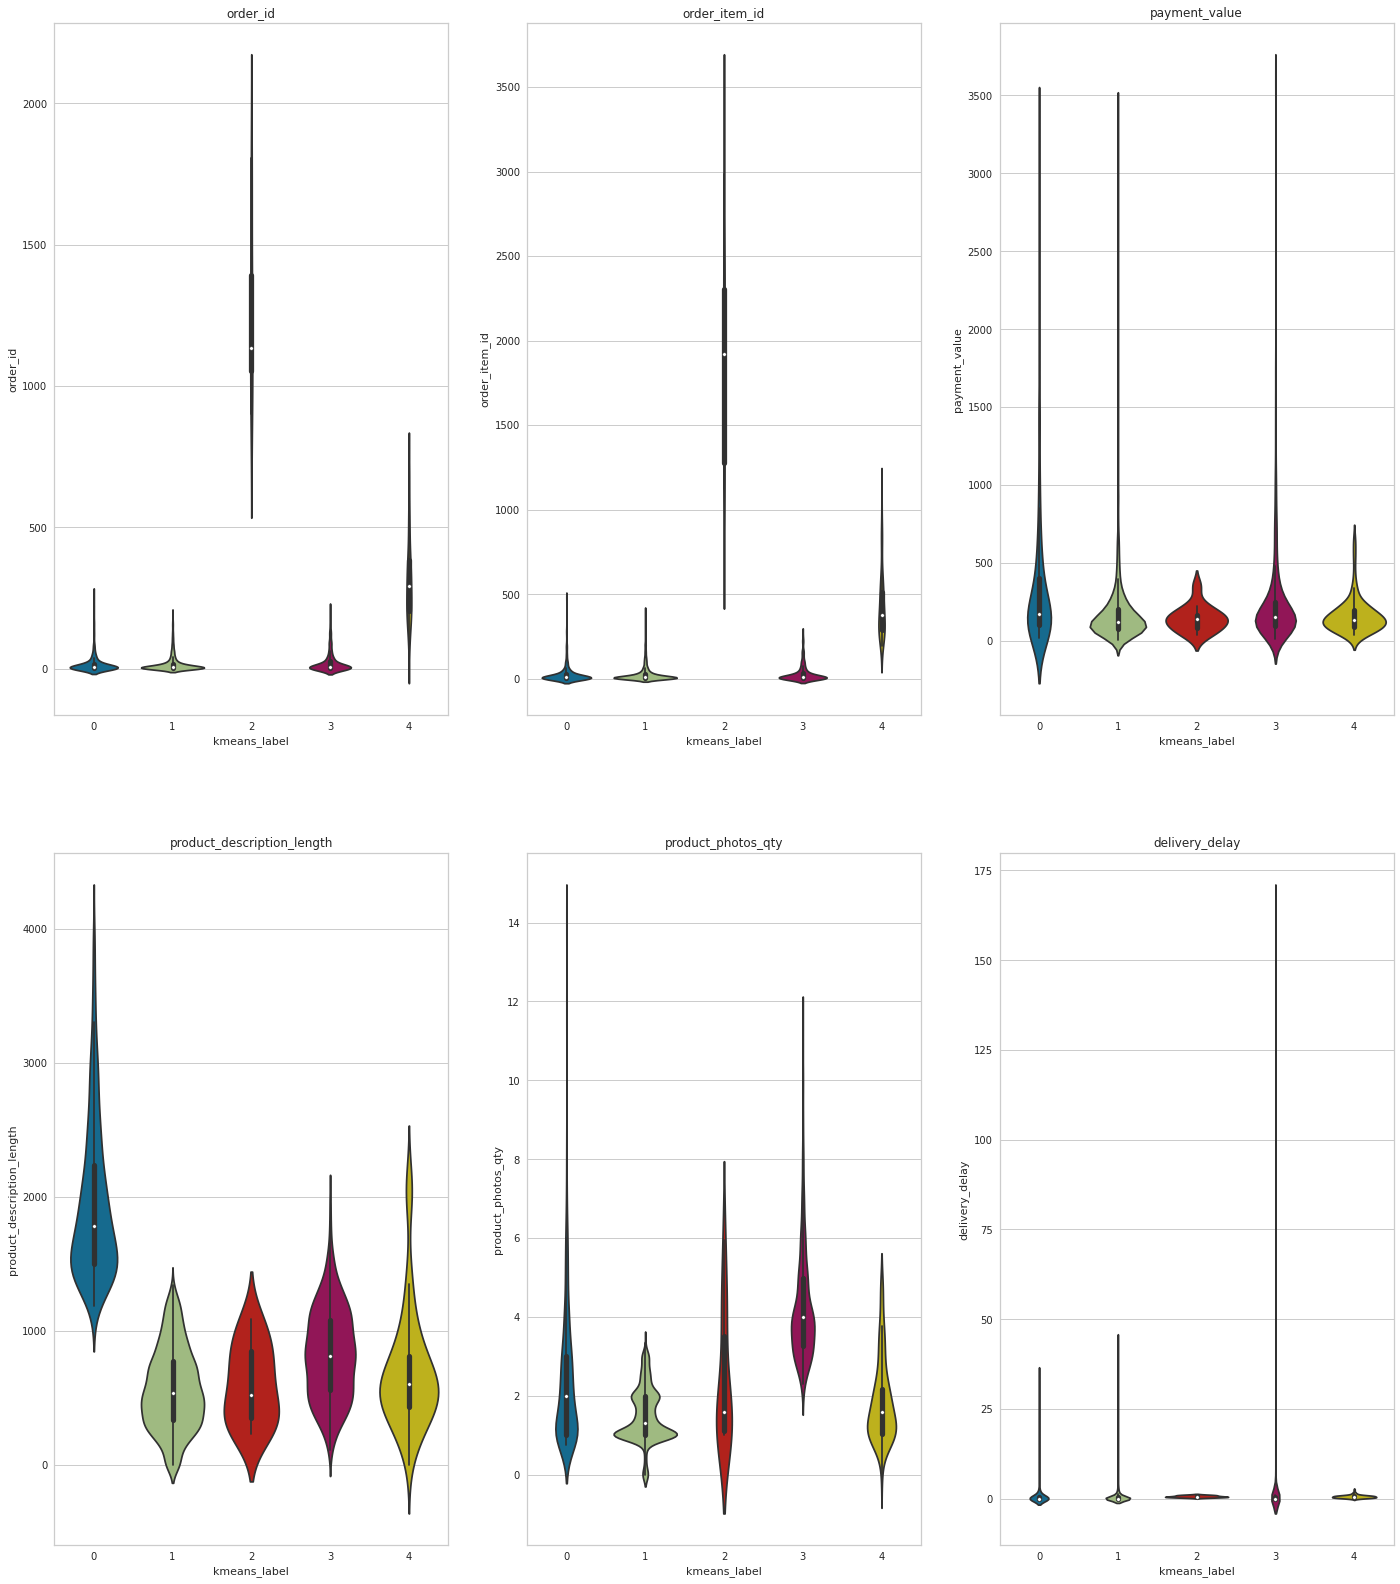

In [102]:
sum_of_columns = X_0.columns
fig = plt.figure(figsize=(24,28))
a = 0; b = 0

for i in sum_of_columns[0:6]:
    axes = plt.subplot2grid((2,3),(a,b))
    sns.violinplot(x = X_0['kmeans_label'],y = X_0[i], ax = axes)
    axes.set_title(i)
    axes.yaxis.grid(True)
    axes.set_xlabel('kmeans_label')
    b = b+1
    if b>=3:
        b = 0
        a = a+1

Berdasarkan kedua plot (scaterplot dan violin plot) di atas, terlihat bahwa persebaran order_id dan order_item_id untuk cluster 4 cenderung memiliki range yang cukup besar (beragam), dan hubungan kedua feature ini adalah linear positif (terlihat dari hasil scatterplot).

Berdasarkan plot terhadap persebaran payment_value, cluster 3 dan 4 memiliki range harga yang cukup besar (beragam). Berbeda dengan cluster lainnya yang kurang lebih berada di bawah 2000. Hal ini akan lebih terlihat pada scatterplot.

Berdasarkan plot terhadap product_description_lenght, cluster 3 adalah kelompok yang memiliki product_description_lenght terpanjang. Sedangkan cluster 2 adalah kelompok yang memiliki product_description_lenght rata-rata pendek. Hal ini akan lebih terlihat pada scatterplot.

Berdasarkan plot terhadap product_photos_qty cluster 0 dan 2 adalah kelompok yang memiliki product_photos_qty yang cenderung stabil (berada di antara 0 - 4 photos). Hal ini akan lebih terlihat pada scatterplot.

Terakhir, berdasarkan plot terhadap delivery_delay, cluster 4 adalah kelompok yang paling sedikit melakukan delay pengiriman. Sedangkan cluster lainnya memiliki rata-rata delivery_delay diantara 0 - 25 hari. Hal ini akan lebih terlihat pada scatterplot.

In [103]:
X_0.groupby(['kmeans_label']).agg({'kmeans_label' : 'count',
                                   'order_id' : ['mean', 'median', 'sum','min','max'],
                                   'payment_value' : 'mean',
                                   'product_description_length' : 'mean',
                                   'product_photos_qty' : 'mean',
                                   'delivery_delay' : ['max','mean'],
                                   'delay_review_response' : 'mean',
                                   'R0' : 'sum',
                                        'R1' : 'sum',
                                        'R2' : 'sum',
                                        'R3' : 'sum',
                                        'R4' : 'sum',
                                        'R5' : 'sum',
                                        'F1' : 'sum',
                                        'F2' : 'sum',
                                        'F3' : 'sum',
                                        'F4' : 'sum',
                                        'F5' : 'sum',
                                        'M0' : 'sum',
                                        'M1' : 'sum',
                                        'M2' : 'sum',
                                        'M3' : 'sum',
                                        'M4' : 'sum',
                                        'M5' : 'sum'
                                   }).T.round(2)

kmeans_label                             0         1         2         3  \
kmeans_label               count    457.00   1828.00     13.00    579.00   
order_id                   mean      17.44     17.88   1260.08     23.07   
                           median     5.00      6.00   1134.00      7.00   
                           sum     7970.00  32682.00  16381.00  13357.00   
                           min        1.00      1.00    902.00      1.00   
                           max      265.00    197.00   1805.00    210.00   
payment_value              mean     360.35    184.29    145.22    240.13   
product_description_length mean    1946.25    567.18    597.22    827.91   
product_photos_qty         mean       2.35      1.49      2.34      4.24   
delivery_delay             max       35.00     44.67      1.07    167.00   
                           mean       0.77      0.77      0.69      0.91   
delay_review_response      mean       2.35      2.70      2.50      2.90   
R0                         sum     1281.00   5923.00   3854.00   2469.00   
R1                         sum     1535.00   6433.00   2352.00   2206.00   
R2                         sum     1771.00   7012.00   3336.00   2754.00   
R3                         sum     1576.00   6098.00   3589.00   2419.00   
R4                         sum     1300.00   5774.00   4277.00   2474.00   
R5                         sum     1950.00   7734.00   2430.00   2911.00   
F1                         sum     8484.00  34474.00  17479.00  13805.00   
F2                         sum      745.00   3607.00   1970.00   1186.00   
F3                         sum       24.00    159.00     68.00     40.00   
F4                         sum       23.00    162.00     28.00     30.00   
F5                         sum      137.00    572.00    293.00    172.00   
M0                         sum     2760.00   6793.00   2357.00   2720.00   
M1                         sum     1203.00   6317.00   4433.00   2451.00   
M2                         sum      847.00   7313.00   3206.00   1751.00   
M3                         sum     1647.00   6106.00   3643.00   2680.00   
M4                         sum     1136.00   6638.00   3248.00   2905.00   
M5                         sum     1820.00   5807.00   2951.00   2726.00   

kmeans_label                              4  
kmeans_label               count      86.00  
order_id                   mean      310.94  
                           median    292.50  
                           sum     26741.00  
                           min        68.00  
                           max       716.00  
payment_value              mean      162.38  
product_description_length mean      700.40  
product_photos_qty         mean        1.86  
delivery_delay             max         2.52  
                           mean        0.66  
delay_review_response      mean        2.59  
R0                         sum      6007.00  
R1                         sum      6386.00  
R2                         sum      4339.00  
R3                         sum      5421.00  
R4                         sum      5184.00  
R5                         sum      4021.00  
F1                         sum     27158.00  
F2                         sum      3211.00  
F3                         sum       214.00  
F4                         sum        93.00  
F5                         sum       682.00  
M0                         sum      5613.00  
M1                         sum      4044.00  
M2                         sum      5853.00  
M3                         sum      5103.00  
M4                         sum      5231.00  
M5                         sum      5514.00

**CLuster 0;**
- R = 5
- F = 1
- M = 0
- tipe customer = New Customer

Cluster 0, grup ini berisi 457 penjual, dengan rata-rata pesanan sebanyak 17.44 dan memiliki rata-rata jumlah transaksi sebesar 360.65. Penjual dalam kelompok ini gemar menuliskan deskripsi produk yang panjang, namun hanya mencantumkan rata-rata 2 foto produk. Pembeli dari cluster ini didominasi oleh tipe new customer, dimana mereka adalah pembeli baru dengan frekuensi pembelian yang sangat kecil dan nominal belanja yang kecil sekali.

Rekomendasi :
1. Ollist Menawarkan program loyalitas bagi pelanggan.
2. Ollist memberikan voucher diskon bagi pengguna baru.
3. Ollist memberikan campaign berupa iklan gratis bagi penjual untuk meningkatkan penjualan (dengan syarat tertentu).

**Cluster 1;**
- R = 5
- F = 1
- M = 2
- tipe customer = Potential Loyalist

Cluster 1 merupakan cluster dengan jumlah penjual terbanyak, yaitu sebanyak 1828 penjual. Rata-rata pesanan dari cluster 1 tidak terlalu jauh berbeda dari cluster 0 yaitu sebesar 17.88, namun cluster ini memiliki rata-rata jumlah transaksi terbesar dengan nilai 32682.00. Penjual pada cluster ini tidak terlalu mendeskripsikan produknya dan hanya menaruh rata-rata 1 foto produk.
Penjual yang masuk dalam cluster 1, didominasi oleh pembeli dengan tipe Potential loyalist, dimana mereka adalah pembeli yang berpotensi untuk menjadi pelaggan loyal meskipun memiliki frekuensi belanja dan nominal yang tidak terlalu besar.

Rekomendasi : 
1. Menawarkan program loyalitas atau voucher diskon; Pertahankan agar pelanggan potensial ini tetap terlibat dengan seller.
2. Dengan jumlah Seller terbesar dan nilai transaksi terbesar, sebaiknya seller dapat mendeskripsikan produk lebih detail dan lengkap, karena seller pada cluster ini menggambarkan sebagian besar seller pada ollist.

**Cluster 2;**
- R = 4
- F = 1
- M = 1
- tipe customer = Promising

Cluster 2 merupakan cluster dengan jumlah anggota paling sedikit yaitu 13 penjual, namun memiliki rata-rata pesanan tertinggi, sebesar 1260.08. Rata-rata nilai transaksi dari cluster ini sebesar 145.22. Penjual dalam cluster ini tidak menuliskan banyak deskripsi dan hanya mencantumkan rata-rata 2 foto produk.Cluster ini didominasi oleh pembeli dengan tipe Promising, dimana mereka adalah pembeli yang berpotensi menjanjikan meskipun frekuensi belanja dan nominal yang tidak terlalu besar.

Rekomendasi :
1. Menawarkan program loyalitas atau voucher diskon.
2. Ollist memasang iklan untuk menarik lebih banyak seller kecil atau non profesional.
3. Ollist memberikan iklan gratis bagi seller lama dan baru dalam cluster ini dengan ketentuan yang sudah ditetapkan sebelumnya.


**Cluster 3;**
- R = 5
- F = 1
- M = 4
- tipe customer = Potential Loyalist

Cluster 3 adalah cluster dengan jumlah anggota terbanyak ke 2 dengan total 579 penjual dengan rata-rata pesanan sebanyak 23.07 dan rata-rata nilai transaksi sebesar 240.13. Penjual dalam cluster ini gemar menuliskan deskripsi produk yang panjang dan mencantumkan rata-rata 4 foto produk. cluster ini memiliki rata-rata keterlambatan pengiriman tertinggi sebesar 0.91. cluster 3 didominasi oleh pembeli dengan tipe Potential Loyalist, dimana mereka adalah pembeli yang berpotensi untuk menjadi pelaggan loyal yang memiliki frekuensi belanja yang kecil namun nominal yang diatas rata-rata.

Rekomendasi :
1. Rekomendasi produk yang dipersonalisasi bagi pelangan loyal.
2. Tingkatkan performa pengiriman.
3. Berikan penawaran khusus bagi pelanggan yang berbelanja di seller cluster ini untuk menjaga loyalitas pelanggan.

**Cluster 4;**
- R = 1
- F = 1
- M = 2
- tipe customer = Hibernating/Lost

Cluster 4 memiliki jumlah anggota sebesar 86 penjual. Rata-rata pesanan dari cluster ini adalah yang terbesar ke-dua sebanyak 310.94 pesanan dengan rata-rata nilai transaksi sebesar 162.38. penjual dalam cluster ini menuliskan deskripsi cukup panjang, namun hanya mencantumkan rata-rata 1 foto produk. Rata-rata keterlambatan pengiriman dari penjual di cluster ini juga cukup kecil hanya sebesar 2.52. Penjual yang masuk dalam cluster 4, didominasi oleh pembeli dengan tipe Hibernating/Lost, dimana mereka adalah pembeli dengan tingkat Recency, Frequency dan Monetary yang rendah dengan kemungkinan pembeli yang sudah tidak aktif.

Rekomendasi :
1. Penawaran promo bagi pelanggan yang kembali.
2. Penjual sebaiknya meningkatkan jumlah foto dalam deskripsi produk agar pelanggan dapat melihat dan mempelajari produk dengan lebih jelas.
3. Ollist memberikan iklan gratis bagi seller lama dan baru dalam cluster ini dengan ketentuan yang sudah ditetapkan sebelumnya.